In [1]:
!pip install catboost
!pip install optuna

In [31]:
import pandas as pd
import scipy
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
from scipy.stats import chi2_contingency, uniform, randint
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from lightgbm import log_evaluation, early_stopping, LGBMClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from scipy.stats import uniform
from sklearn.ensemble import VotingClassifier
import catboost as cb

In [3]:
train_data = pd.read_csv('train_snbp.csv')
test_data = pd.read_csv('test_snbp.csv')

#Explanatory Data Analysis

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15157 entries, 0 to 15156
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       14433 non-null  float64
 1   jenis_kelamin            15157 non-null  object 
 2   usia                     14430 non-null  float64
 3   tahun                    14385 non-null  float64
 4   akreditasi_sekolah       15157 non-null  object 
 5   prov                     14415 non-null  object 
 6   kls10_sem1_Matematika    15031 non-null  float64
 7   kls10_sem1_Fisika        14794 non-null  float64
 8   kls10_sem1_Kimia         14059 non-null  float64
 9   kls10_sem1_Biologi       14793 non-null  float64
 10  kls10_sem1_BhsIndonesia  15031 non-null  float64
 11  kls10_sem1_BhsInggris    15031 non-null  float64
 12  kls10_sem2_Matematika    15068 non-null  float64
 13  kls10_sem2_Fisika        14831 non-null  float64
 14  kls10_sem2_Kimia      

In [ ]:
train_data.head()

,id,jenis_kelamin,usia,tahun,akreditasi_sekolah,prov,kls10_sem1_Matematika,kls10_sem1_Fisika,kls10_sem1_Kimia,kls10_sem1_Biologi,...,kls12_sem1_Biologi,kls12_sem1_BhsIndonesia,kls12_sem1_BhsInggris,pres1_jenjang,pres2_jenjang,pres3_jenjang,juara_pres1,juara_pres2,juara_pres3,status_kelulusan
0,29241.0,P,18.0,NaN,A,Prov. Jawa Timur,89.0,83.0,88.0,88.0,...,92.0,93.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN,Tidak Lulus
1,11259.0,L,17.0,2023.0,A,Prov. Jawa Timur,94.0,94.0,93.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tidak Lulus
2,21436.0,L,19.0,2022.0,A,Prov. Jawa Timur,90.0,84.0,85.0,85.0,...,90.0,92.0,90.0,Nasional,NaN,NaN,Juara 3,NaN,NaN,Lulus
3,19980.0,L,19.0,NaN,A,Prov. Bengkulu,84.0,84.0,79.0,71.0,...,92.0,93.0,90.0,Kabupaten/Kota,Propinsi,Propinsi,NaN,NaN,NaN,Tidak Lulus
4,18212.0,L,NaN,2023.0,A,Prov. Jawa Timur,83.0,83.0,77.0,86.0,...,87.0,90.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN,Tidak Lulus


In [ ]:
train_data.describe()

,id,usia,tahun,kls10_sem1_Matematika,kls10_sem1_Fisika,kls10_sem1_Kimia,kls10_sem1_Biologi,kls10_sem1_BhsIndonesia,kls10_sem1_BhsInggris,kls10_sem2_Matematika,...,kls11_sem2_Kimia,kls11_sem2_Biologi,kls11_sem2_BhsIndonesia,kls11_sem2_BhsInggris,kls12_sem1_Matematika,kls12_sem1_Fisika,kls12_sem1_Kimia,kls12_sem1_Biologi,kls12_sem1_BhsIndonesia,kls12_sem1_BhsInggris
count,14433.000000,14430.000000,14385.000000,15031.000000,14794.000000,14059.000000,14793.000000,15031.000000,15031.000000,15068.000000,...,15053.000000,14276.000000,15141.000000,15141.000000,14783.000000,13944.000000,14700.000000,14695.000000,14088.000000,14044.000000
mean,15747.815769,18.294109,2022.963730,84.624137,84.107185,84.497048,84.168958,84.960907,85.169288,86.328730,...,88.253677,88.582845,89.395212,89.265887,91.022228,89.952861,89.886136,90.152385,91.066383,90.842011
std,8527.697430,0.574711,0.824828,5.549337,5.456148,5.302946,8.067652,4.834739,5.169282,5.250031,...,8.084504,8.128339,4.287499,4.606877,4.728583,8.194066,8.227604,8.311699,4.316010,4.387418
min,1.000000,16.000000,2021.751323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8441.000000,18.000000,2022.000000,81.000000,80.000000,81.000000,82.000000,82.000000,82.000000,83.000000,...,86.000000,86.000000,87.000000,87.000000,88.000000,88.000000,88.000000,88.000000,89.000000,88.000000
50%,16170.000000,18.000000,2023.000000,85.000000,84.000000,85.000000,84.000000,85.000000,85.000000,86.000000,...,89.000000,89.000000,90.000000,90.000000,91.800000,91.000000,91.000000,91.000000,92.000000,91.000000
75%,23351.000000,19.000000,2024.000000,88.000000,88.000000,88.000000,88.000000,88.000000,89.000000,90.000000,...,92.000000,92.000000,92.000000,92.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
max,29536.000000,23.000000,2024.155031,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


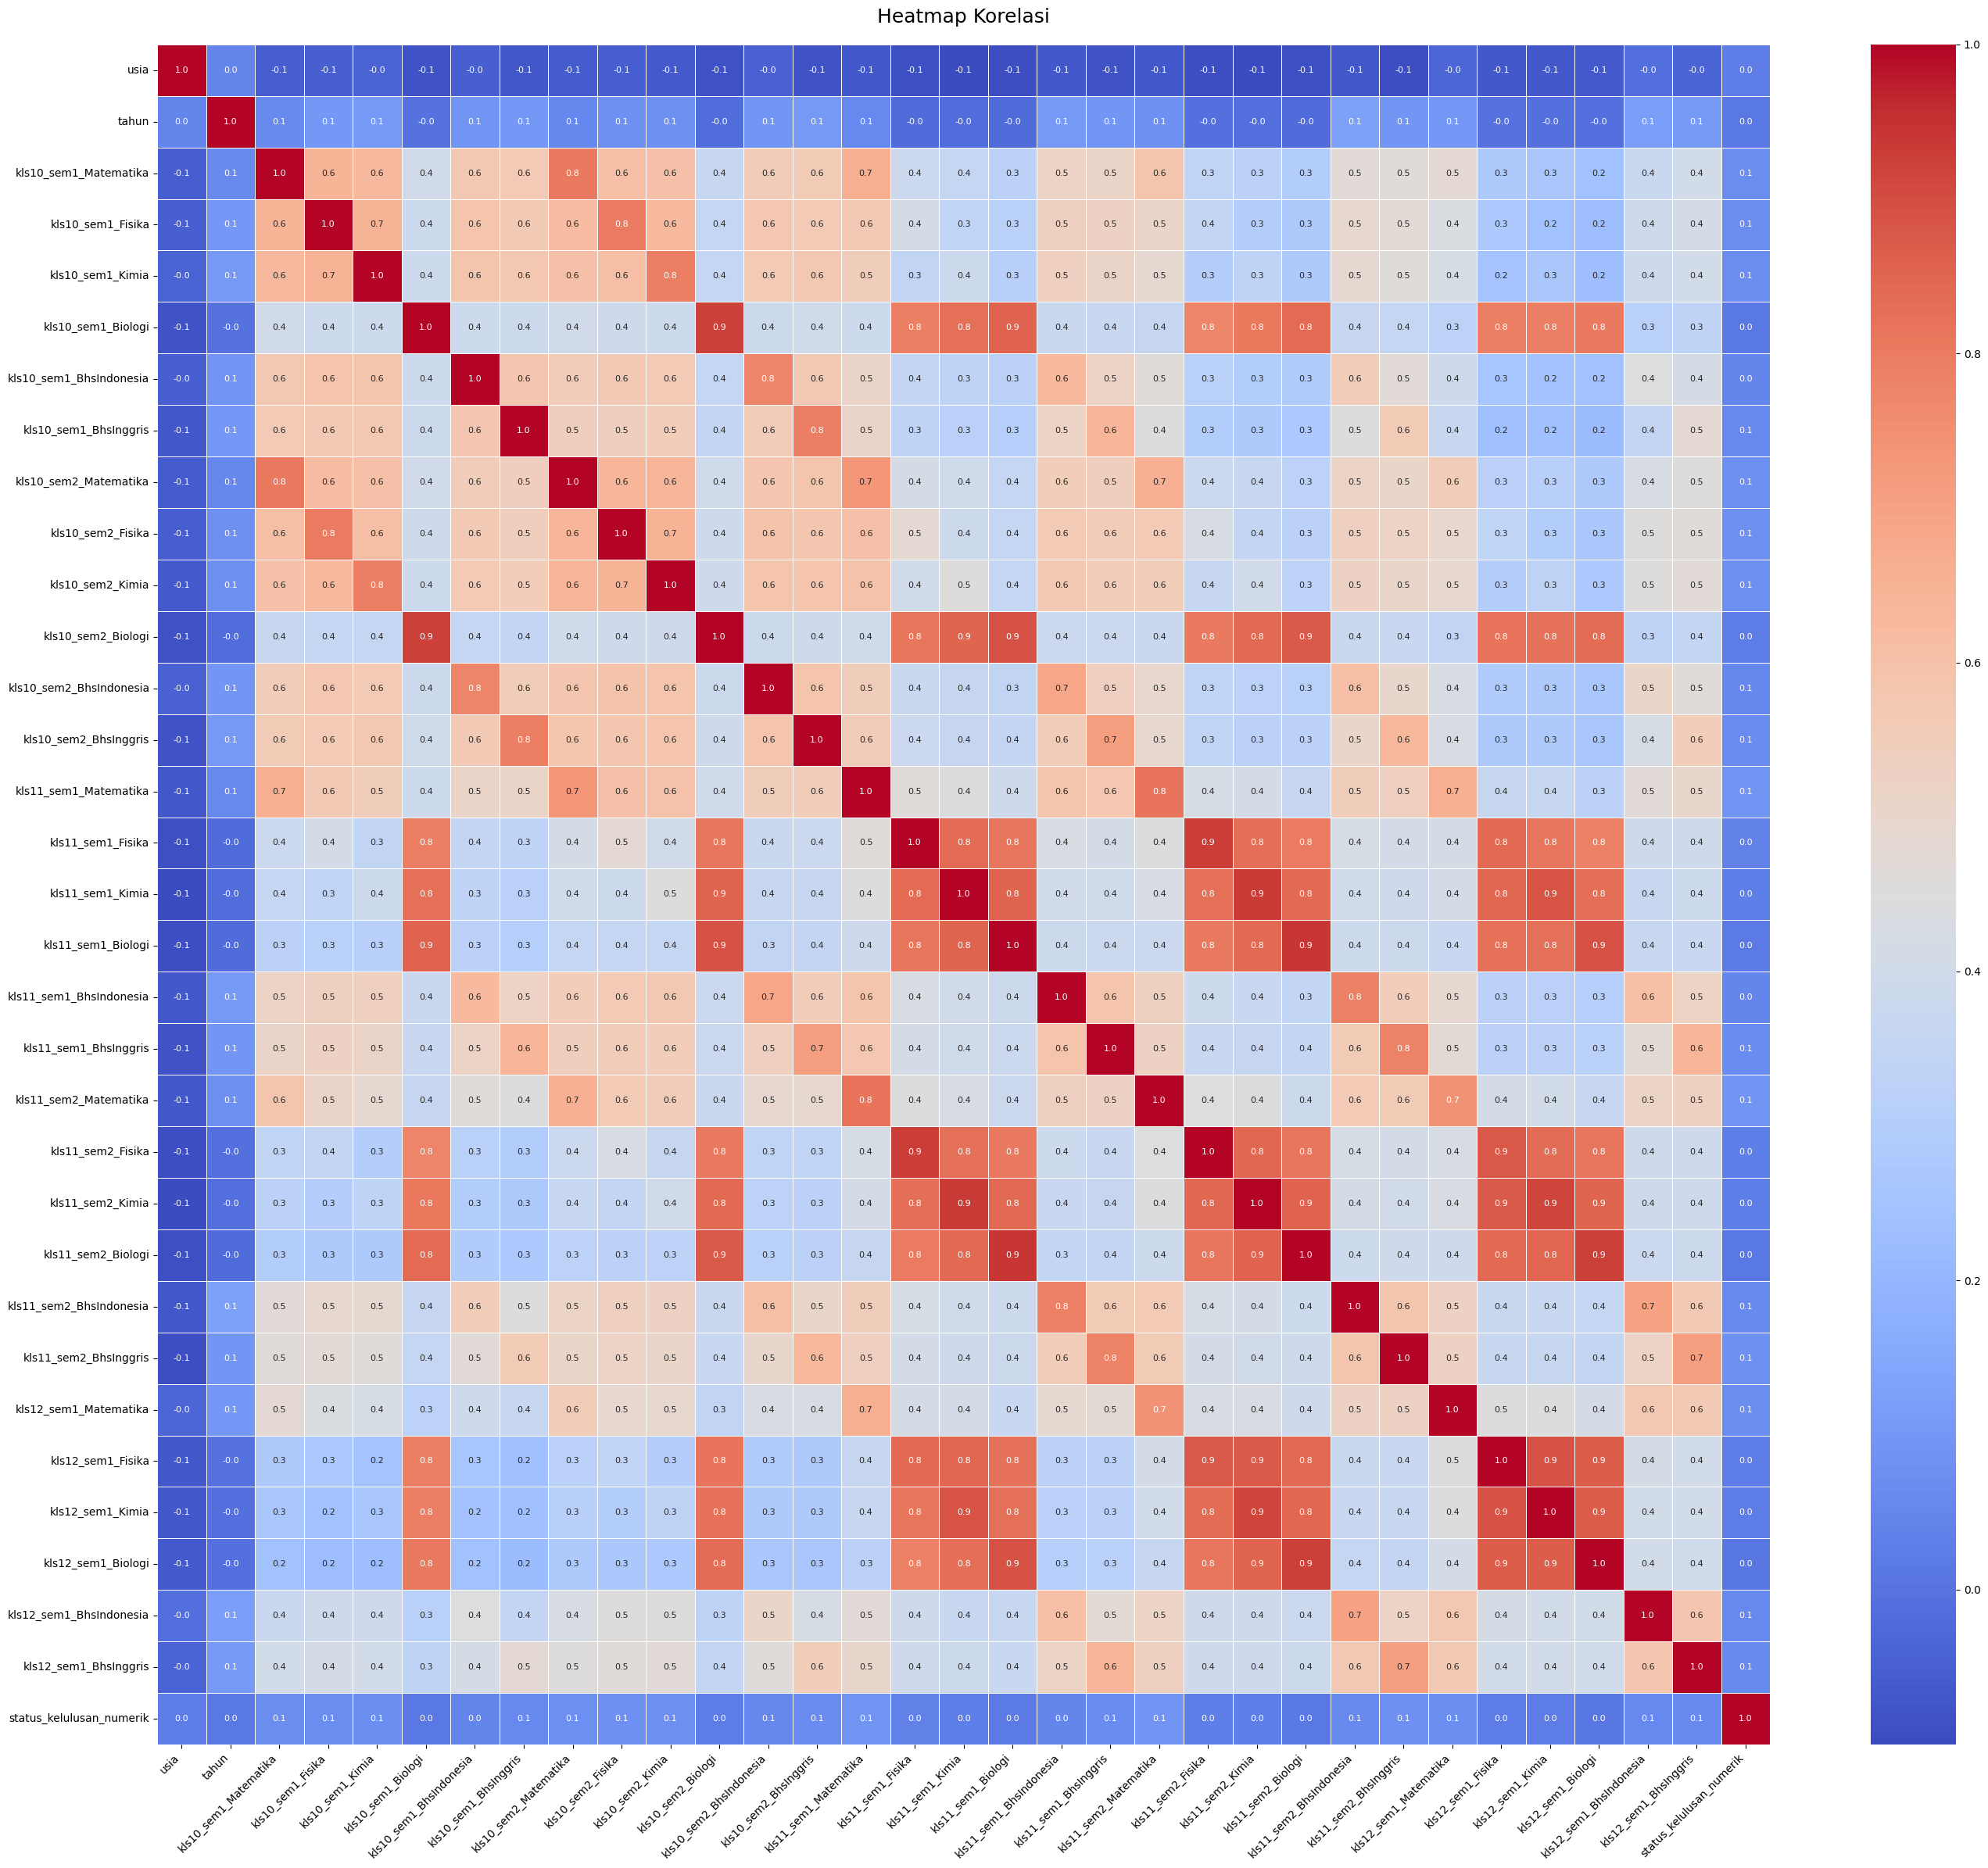

In [ ]:
train_data['status_kelulusan_numerik'] = train_data['status_kelulusan'].map({'Lulus': 1, 'Tidak Lulus': 0})

numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

if 'status_kelulusan_numerik' not in numeric_cols and 'status_kelulusan_numerik' in train_data.columns:
    train_data['status_kelulusan_numerik'] = pd.to_numeric(df['status_kelulusan_numerik'], errors='coerce')
    if pd.api.types.is_numeric_dtype(train_data['status_kelulusan_numerik']) and 'status_kelulusan_numerik' not in potential_numeric_cols:
       numeric_cols.append('status_kelulusan_numerik')


if 'id' in numeric_cols:
    numeric_cols.remove('id')

correlation_matrix_overall = train_data[numeric_cols].corr()

plt.figure(figsize=(28, 24))
sns.heatmap(correlation_matrix_overall, annot=True, cmap='coolwarm', fmt='.1f', annot_kws={"size": 8}, linewidths=.5)
plt.title('Heatmap Korelasi', fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
missing_data = train_data.isnull().sum()
missing_percent = (missing_data / len(train_data)) * 100

missing_data = pd.DataFrame({'Jumlah Missing': missing_data, 'Persentase Missing': missing_percent})
missing_data

,Jumlah Missing,Persentase Missing
id,724,4.776671
jenis_kelamin,0,0.000000
usia,727,4.796464
tahun,772,5.093356
akreditasi_sekolah,0,0.000000
prov,742,4.895428
kls10_sem1_Matematika,126,0.831299
kls10_sem1_Fisika,363,2.394933
kls10_sem1_Kimia,1098,7.244178
kls10_sem1_Biologi,364,2.401531


Dari, hasil tersebut beberapa nilai rapot itu missing dan prestasi paling banyak missing, hal tersebut bisa juga mempengaruhi karena prestasi jika dilihat dari datanya menentukan apakah siswa memiliki prestasi atau tidak

missing values pada nilai serta prestasi sebaiknya tidak dihapus karena nilai dan prestasi memang beberapa diperlukan kosong.

### Status Kelulusan

/tmp/ipython-input-9-3935268616.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status_kelulusan', data=train_data, palette='viridis')


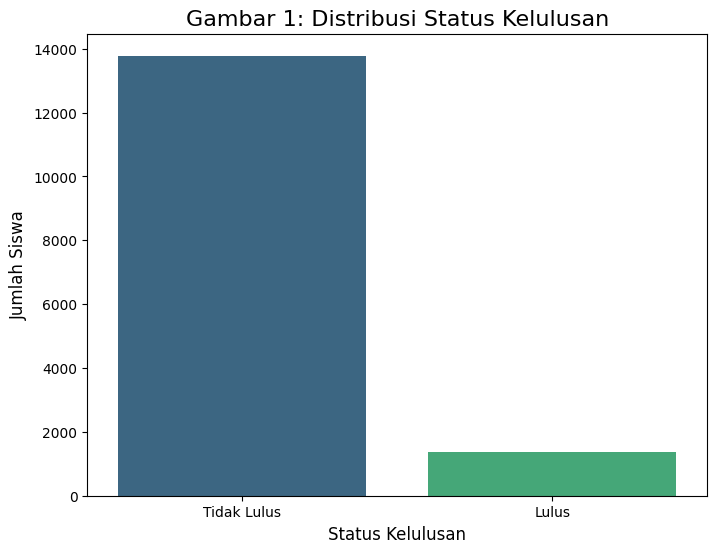

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='status_kelulusan', data=train_data, palette='viridis')
plt.title('Gambar 1: Distribusi Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Siswa', fontsize=12)
plt.show()

In [ ]:
target_counts = train_data['status_kelulusan'].value_counts()
target_percent = train_data['status_kelulusan'].value_counts(normalize=True) * 100

print(target_percent)

status_kelulusan
Tidak Lulus    90.908491
Lulus           9.091509
Name: proportion, dtype: float64


Dari tabel tersebut dapat dilihat bahwa jumlah siswa yang tidak lulus berbanding jauh dengan jumlah yang lulus, sehingga dataset ini merupakan data yang imbalance

### Prestasi

#### Jenjang 1

/tmp/ipython-input-11-521465365.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['pres1_jenjang'].fillna('Tidak Ada Prestasi', inplace=True)


KeyboardInterrupt: 

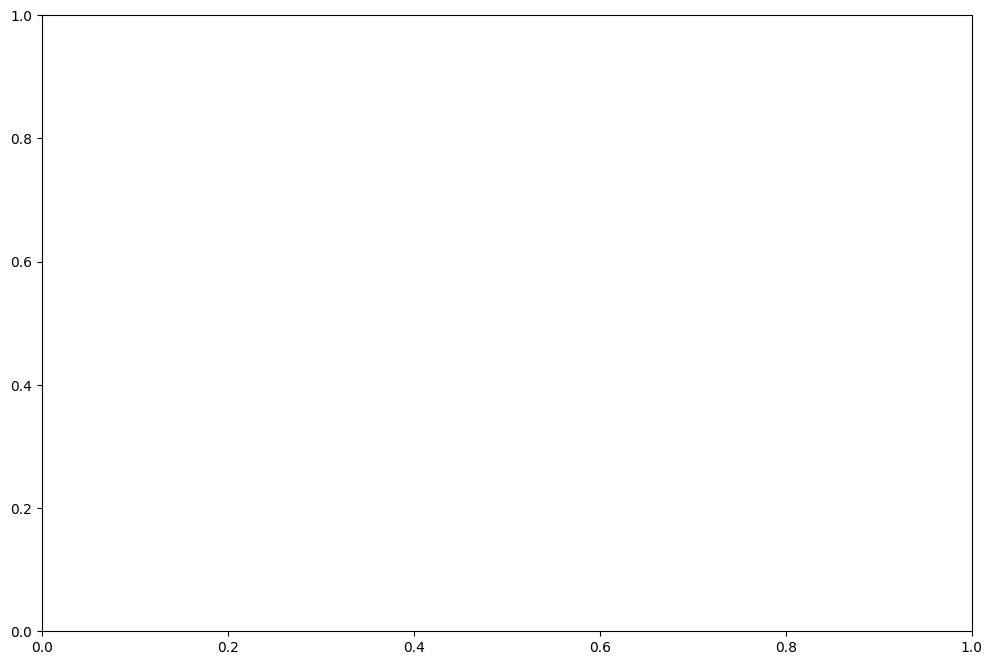

In [ ]:
train_data['pres1_jenjang'].fillna('Tidak Ada Prestasi', inplace=True)

plt.figure(figsize=(12, 8))
sns.countplot(
    y='pres1_jenjang',
    hue='status_kelulusan',
    data=train_data,
    palette={'Lulus': 'seagreen', 'Tidak Lulus': 'salmon'},
    order=train_data['pres1_jenjang'].value_counts().index
)

plt.title('Jumlah Siswa Lulus vs Tidak Lulus pada Jenjang 1 Prestasi', fontsize=16, pad=20)
plt.xlabel('Jumlah Siswa', fontsize=12)
plt.ylabel('Jenjang Prestasi Pertama', fontsize=12)
plt.legend(title='Status Kelulusan')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

#### Jenjang 2

In [ ]:
train_data['pres2_jenjang'].fillna('Tidak Ada Prestasi', inplace=True)

plt.figure(figsize=(12, 8))
sns.countplot(
    y='pres2_jenjang',
    hue='status_kelulusan',
    data=train_data,
    palette={'Lulus': 'seagreen', 'Tidak Lulus': 'salmon'},
    order=train_data['pres1_jenjang'].value_counts().index
)

plt.title('Jumlah Siswa Lulus vs Tidak Lulus pada Jenjang 2 Prestasi', fontsize=16, pad=20)
plt.xlabel('Jumlah Siswa', fontsize=12)
plt.ylabel('Jenjang Prestasi Kedua', fontsize=12)
plt.legend(title='Status Kelulusan')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

#### Jenjang 3

In [ ]:
train_data['pres3_jenjang'].fillna('Tidak Ada Prestasi', inplace=True)

plt.figure(figsize=(12, 8))
sns.countplot(
    y='pres3_jenjang',
    hue='status_kelulusan',
    data=train_data,
    palette={'Lulus': 'seagreen', 'Tidak Lulus': 'salmon'},
    order=train_data['pres1_jenjang'].value_counts().index
)

plt.title('Jumlah Siswa Lulus vs Tidak Lulus pada Jenjang 3 Prestasi', fontsize=16, pad=20)
plt.xlabel('Jumlah Siswa', fontsize=12)
plt.ylabel('Jenjang Prestasi Ketiga', fontsize=12)
plt.legend(title='Status Kelulusan')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

###Jenis Kelamin

In [ ]:
contingency_table = pd.crosstab(train_data['jenis_kelamin'], train_data['status_kelulusan'])


proportions = contingency_table.apply(lambda x: x/x.sum(), axis=1)

print("--- Proporsi Kelulusan per Jenis Kelamin ---")
print(proportions)

proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 7),
    color=['seagreen', 'salmon']
)

plt.title('Proporsi Kelulusan Berdasarkan Jenis Kelamin', fontsize=16)
plt.xlabel('Jenis Kelamin', fontsize=12)
plt.ylabel('Proporsi (Persentase)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Status Kelulusan', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Jenis kelamin menjadi pertimbangan untuk di drop, karena dalam SNBP jenis kelamin tidak menjadi pengaruh untuk lulus atau tidak. Maka, sebaiknya bisa di tes untuk menyertakan jenis kealmin dan tidak.

###Tahun

Setiap tahun, jenis murid yang diterima berbeda--beda, sehingga tahun perlu menjadi faktor pertimbangan untuk kelulusan snbp. Tapi, tahun masih ada yang berupa float dan masih ada missing values

Cek distribusi untuk melihat apa yang cocok untuk mengisi missing values usia

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.histplot(train_data['tahun'], bins=10, kde=True)
plt.title('Distribusi Tahun (Histogram)', fontsize=15)
plt.xlabel('Tahun')
plt.ylabel('Frekuensi (Jumlah Orang)')
plt.show()

Disini bisa dilihat bahwa usia seperti lebih ke kategori, sehingga bisa membuat value baru yaitu tidak diketahui agar tidak menimbulkan kesalahan

###Usia

Terdapat beberapa missing values pada umur, namun umur bukanlah penentu utama untuk SNBP. Karena di SNBP hampir tidak mempedulikan umur, SNBP mengutamakan prestasi, sehingga bisa dipertimbangkan untuk di drop. Namun harus dilihat ada berapa umur yang diatas 25, karena maksimal umur SNBP 25.

Cek apakah ada umur siswa yang diatas 25.

In [ ]:
diatas_25 = train_data[train_data['usia'] > 25]
display(diatas_25)

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.histplot(train_data['usia'], bins=10, kde=True)
plt.title('Distribusi Usia (Histogram)', fontsize=15)
plt.xlabel('Usia')
plt.ylabel('Frekuensi (Jumlah Orang)')
plt.show()

Disini distribusi lebih ke arah 18 tahun, maka jika mengisi missing values menjadi median atau mean nanti akan mengisi ke 18 tahun dimana itu menjadi tidak akurat, sehingga lebih baik diubah menjadi kategori "tidak diketahui"

###Provinsi

In [ ]:
train_data['prov'] = train_data['prov'].str.replace('Prov. ', '', regex=False).str.strip() #membersihkan nama prov.

kelulusan_per_prov = train_data.groupby(['prov', 'status_kelulusan']).size().unstack(fill_value=0) #hitung jumlah lulus

kelulusan_per_prov['Persentase_Lulus'] = (
    kelulusan_per_prov.get('Lulus', 0) / kelulusan_per_prov.sum(axis=1)
) * 100

kelulusan_per_prov_sorted = kelulusan_per_prov.sort_values(by='Persentase_Lulus', ascending=False)

plt.figure(figsize=(12, 8))
kelulusan_per_prov_sorted['Persentase_Lulus'].plot(kind='bar', color='skyblue')
plt.title('Persentase Kelulusan SNBP per Provinsi')
plt.ylabel('Persentase Lulus (%)')
plt.xlabel('Provinsi')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

kelulusan_per_prov_sorted.head(38)


Dari hasil analisis tersebut, beberapa provinsi dengan persentase lulus teratas memiliki jumlah peserta yang sangat sedikit, sehingga kita tidak bisa mengambil keputusan dengan persentase ini. Namun, kita juga tahu bahwa Provinsi Jawa Timur adalah modusnya, dengan proporsi yang jauh lebih banyak dibanding provinsi lainnya.

###Akreditasi

In [ ]:
#handle missing values akreditasi
train_data['akreditasi_sekolah'].fillna('Tidak Diketahui', inplace=True)


#plot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=train_data,
    x='akreditasi_sekolah',
    hue='status_kelulusan',
    order=['A', 'B', 'C'],
    palette={'Lulus': 'lightgreen', 'Tidak Lulus': 'salmon'}
)
plt.title('Jumlah Siswa Lulus & Tidak Lulus Berdasarkan Akreditasi Sekolah', fontsize=16, pad=20)
plt.xlabel('Akreditasi Sekolah', fontsize=12)
plt.ylabel('Jumlah Siswa', fontsize=12)
plt.legend(title='Status Kelulusan')
plt.tight_layout()
plt.savefig('plot_jumlah_akreditasi_kelulusan.png')
plt.show()


tingkat_lulus_akreditasi = train_data.groupby('akreditasi_sekolah')['status_kelulusan_numerik'].agg(['mean', 'count']).rename(
    columns={'mean': 'tingkat_kelulusan', 'count': 'jumlah_pendaftar'}
).sort_values(by='tingkat_kelulusan', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=tingkat_lulus_akreditasi.index,
    y=tingkat_lulus_akreditasi['tingkat_kelulusan'],
    palette='plasma',
    order=['A', 'B', 'C']
)
plt.title('Tingkat Kelulusan SNBP Berdasarkan Akreditasi Sekolah', fontsize=16, pad=20)
plt.xlabel('Akreditasi Sekolah', fontsize=12)
plt.ylabel('Tingkat Kelulusan', fontsize=12)
plt.ylim(0, max(tingkat_lulus_akreditasi['tingkat_kelulusan']) * 1.15)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=11,
                fontweight='bold')

plt.tight_layout()
plt.savefig('plot_tingkat_lulus_akreditasi.png')
plt.show()

print("Tabel Tingkat Kelulusan dan Jumlah Pendaftar per Akreditasi Sekolah:")
print(tingkat_lulus_akreditasi)

###Nilai

Pada fitur nilai mapel ada beberapa keanehan pada valuenya
- Terdapat nilai dengan skala 10 yang mana seharusnya skala 100
- Terdapat nilai 0 dan NaN

Cek apakah nilai 0 dan NaN ini merupakan kesalahan input atau memang disengaja

In [ ]:
mata_pelajaran_cols = [col for col in train_data.columns if col.startswith('kls')]

nilai_0_atau_nan = (train_data[mata_pelajaran_cols] == 0) | (train_data[mata_pelajaran_cols].isna())
siswa_bernilai_0_nan = nilai_0_atau_nan.any(axis=1)

jumlah_lulus = (siswa_bernilai_0_nan & (train_data['status_kelulusan'] == 'Lulus')).sum()
jumlah_tidak_lulus = (siswa_bernilai_0_nan & (train_data['status_kelulusan'] == 'Tidak Lulus')).sum()

print(f"Siswa dengan nilai 0/NaN dan LULUS: {jumlah_lulus}")
print(f"Siswa dengan nilai 0/NaN dan TIDAK LULUS: {jumlah_tidak_lulus}")

Dapat dilihat bahwa siswa yang terdapat value 0 atau NaN pada nilai rapot semesternya masih banyak yang diterima, oleh karena itu kami berasumsi bahwa ada kemungkinan nilai 0 atau NaN ini adalah kesalahan input dan bukan memang nilai riil siswa yang 0 ataupun tidak ada nilainya.

#Skenario 1: Tanpa Preprocess

##Training

Persiapan data training untuk Gradient Booster menggunakan native karena sudah termasuk handling missing values

In [4]:
X = train_data.drop(['id', 'status_kelulusan'], axis=1)
y = train_data['status_kelulusan']
categorical_cols = ['jenis_kelamin', 'akreditasi_sekolah', 'prov',
                   'pres1_jenjang', 'pres2_jenjang', 'pres3_jenjang',
                   'juara_pres1', 'juara_pres2', 'juara_pres3']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

for col in categorical_cols:
      X[col] = X[col].fillna('missing')

#Catboost
X_train_catboost = X.copy()
for col in categorical_cols:
    X_train_catboost[col] = X_train_catboost[col].astype(str)

#XGBoost
X_train_xgboost = X.copy()
for col in categorical_cols:
    X_train_xgboost[col] = X_train_xgboost[col].astype('category')

#LGBM
X_train_lgbm = X.copy()
for col in categorical_cols:
    X_train_lgbm[col] = X_train_lgbm[col].astype('category')

#Untuk model lain
encoder = LabelEncoder()
for col in categorical_cols:
    if col in X.columns:
        X[col] = encoder.fit_transform(X[col])

#Model selain gradient booster tidak bisa mengatasi missing values
X = X.fillna(X.median())

### Training Data Catboost

In [ ]:
catboost_model = CatBoostClassifier(
    cat_features=categorical_cols,
    random_state=100,
    verbose=False
)

catboost_model.fit(X_train_catboost, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

y_pred = cross_val_predict(catboost_model, X_train_catboost, y, cv=cv)
y_proba = cross_val_predict(catboost_model, X_train_catboost, y, cv=cv, method='predict_proba')[:,1]

print("CatBoost Cross-Validation Metrics:")
print(classification_report(y, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")

CatBoost Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.3333    0.0015    0.0029      1378
 Tidak Lulus     0.9092    0.9997    0.9523     13779

    accuracy                         0.9090     15157
   macro avg     0.6213    0.5006    0.4776     15157
weighted avg     0.8568    0.9090    0.8660     15157

ROC AUC: 0.6739


###Training Data XGBoost

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y) #ganti ke binary agar bisa diproses xgboost

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=100, enable_categorical=True)

xgb_model.fit(X_train_xgboost, y_encoded)

y_pred_encoded = cross_val_predict(xgb_model, X_train_xgboost, y_encoded, cv=cv)
y_proba = cross_val_predict(xgb_model, X_train_xgboost, y_encoded, cv=cv, method='predict_proba')[:,1]

y_pred = le.inverse_transform(y_pred_encoded)

print("XGBoost Cross-Validation Metrics:")
print(classification_report(y, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_encoded, y_proba):.4f}")

XGBoost Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.2545    0.0203    0.0376      1378
 Tidak Lulus     0.9103    0.9940    0.9503     13779

    accuracy                         0.9055     15157
   macro avg     0.5824    0.5072    0.4940     15157
weighted avg     0.8507    0.9055    0.8673     15157

ROC AUC: 0.6526


###Training Data LightGBM

In [ ]:
lgbm_model = lgb.LGBMClassifier(random_state=100)

lgbm_model.fit(X_train_lgbm, y)

y_pred = cross_val_predict(lgbm_model, X_train_lgbm, y, cv=cv)
y_proba = cross_val_predict(lgbm_model, X_train_lgbm, y, cv=cv, method='predict_proba')[:,1]


print("LightGBM Cross-Validation Metrics:")
print(classification_report(y, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")

Label Encoder karena metode selain gradient boosting tidak menghandle mising values secara native, sehingga missing values disini diatasi dengan menggunakan median.

###Training Data SVM

In [ ]:
svm_model = SVC(probability=True, random_state=100)

svm_model.fit(X, y)

y_pred = cross_val_predict(svm_model, X, y, cv=cv)
y_proba = cross_val_predict(svm_model, X, y, cv=cv, method='predict_proba')[:,1]

print("SVM Cross-Validation Metrics:")
print(classification_report(y, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")

###Training Data Logistic Regression

In [ ]:
logreg_model = LogisticRegression(random_state=100)

logreg_model.fit(X, y)

y_pred = cross_val_predict(logreg_model, X, y, cv=cv)
y_proba = cross_val_predict(logreg_model, X, y, cv=cv, method='predict_proba')[:,1]

print("Logistic Regression Cross-Validation Metrics:")
print(classification_report(y, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")

###Training Data Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=100)

rf_model.fit(X, y)

y_pred = cross_val_predict(rf_model, X, y, cv=cv)
y_proba = cross_val_predict(rf_model, X, y, cv=cv, method='predict_proba')[:,1]

print("Random Forest Cross-Validation Metrics:")
print(classification_report(y, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")

##Testing

Persiapan Test Data

In [5]:
X_test = test_data.drop(['id'], axis=1)

categorical_cols = ['jenis_kelamin', 'akreditasi_sekolah', 'prov',
                   'pres1_jenjang', 'pres2_jenjang', 'pres3_jenjang',
                   'juara_pres1', 'juara_pres2', 'juara_pres3']

for col in categorical_cols:
    X_test[col] = X_test[col].fillna('missing')

X_test_catboost = X_test.copy()
for col in categorical_cols:
    X_test_catboost[col] = X_test_catboost[col].astype(str)

X_test_xgboost = X_test.copy()
for col in categorical_cols:
    X_test_xgboost[col] = X_test_xgboost[col].astype('category')

X_test_lgbm = X_test.copy()
for col in categorical_cols:
    X_test_lgbm[col] = X_test_lgbm[col].astype('category')

y_test_true = test_data['status_kelulusan']

X_test_processed = X_test.copy()
encoder = LabelEncoder()
for col in categorical_cols:
    if col in X_test_processed.columns:
        X_test_processed[col] = X_test_processed[col].fillna('Missing')
        X_test_processed[col] = encoder.fit_transform(X_test_processed[col])

X_test_processed = X_test_processed.fillna(X.median())

X_test_catboost.drop(['status_kelulusan'], axis=1, inplace=True)
X_test_xgboost.drop(['status_kelulusan'], axis=1, inplace=True)
X_test_lgbm.drop(['status_kelulusan'], axis=1, inplace=True)
X_test_processed.drop(['status_kelulusan'], axis=1, inplace=True)

###Test Catboost



In [ ]:
y_test_pred = catboost_model.predict(X_test_catboost)
y_test_proba = catboost_model.predict_proba(X_test_catboost)[:,1]

print("Catboost Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred)

print("\nConfusion Matrix:")
print(cm)

Catboost Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     1.0000    0.0032    0.0063       315
 Tidak Lulus     0.8298    1.0000    0.9070      1531

    accuracy                         0.8299      1846
   macro avg     0.9149    0.5016    0.4567      1846
weighted avg     0.8589    0.8299    0.7533      1846

ROC AUC: 0.6912

Confusion Matrix:
[[   1  314]
 [   0 1531]]


F1 score dari Catboost cukup baik yaitu 83% yaitu ia berhasil memprediksi cukup baik untuk dataset ini. Namun, untuk True Positive, ia hanya berhasil memprediksi 1 yang benar dari antara 315 total data lulus, sehingga hasilnya masih kurang baik. Ia sudah bagus bisa tidak menimbulkan False Negative sama sekali. CatBoost memprediksi Tidak Lulus dengan cukup baik.

In [ ]:
feature_importance = catboost_model.get_feature_importance(prettified=True)

print("\nCatBoost Feature Importance:")
print(feature_importance)

###Test XGBoost

In [ ]:
y_test_encoded = le.transform(y_test_true)

y_test_pred_encoded = xgb_model.predict(X_test_xgboost)
y_test_proba = xgb_model.predict_proba(X_test_xgboost)[:,1]

y_test_pred = le.inverse_transform(y_test_pred_encoded)

print("XGBoost Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_encoded, y_test_proba):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred)

print("\nConfusion Matrix:")
print(cm)

XGBoost Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.3333    0.0032    0.0063       315
 Tidak Lulus     0.8296    0.9987    0.9063      1531

    accuracy                         0.8288      1846
   macro avg     0.5815    0.5009    0.4563      1846
weighted avg     0.7449    0.8288    0.7528      1846

ROC AUC: 0.5813

Confusion Matrix:
[[   1  314]
 [   2 1529]]


Sama seperti Catboost, XGBoost memiliki akurasi 83% juga, ia juga berhasil memprediksi 1 True Positive, namun ia salah memprediksi 2 positif menjadi negatif sehingga presisi untuk lulusnya 33% yang lebih buruk dari CatBoost. Untuk memprediksi kasus Tidak Lulus, XGBoost berperforma cukup baik.

In [ ]:
feature_importances = xgb_model.feature_importances_
feature_importance_series = pd.Series(feature_importances, index=X_train_xgboost.columns)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

print("\nXGBoost Feature Importance:")
print(sorted_feature_importances)

###Test LightGBM

In [ ]:
y_test_pred = lgbm_model.predict(X_test_lgbm)
y_test_proba = lgbm_model.predict_proba(X_test_lgbm)[:,1]

print("Logistic Regression Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred)

print("\nConfusion Matrix:")
print(cm)

LightGBM memiliki performa yang lebih buruk dari kedua gradient boosting model lainnya, LightGBM tidak berhasil sama sekali memprediksi True Positif dan malah menghasilkan 2 False Negatif, namun untuk performa memprediksi Tidak Lulus hampir sama seperti yang lain.

In [ ]:
feature_importances = lgbm_model.feature_importances_
feature_importance_series = pd.Series(feature_importances, index=X_train_lgbm.columns)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

print("\nLightGBM Feature Importance:")
sorted_feature_importances

###Test SVM

In [ ]:
y_test_pred = svm_model.predict(X_test_processed)
y_test_proba = svm_model.predict_proba(X_test_processed)[:,1]

print("SVM Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred)

print("\nConfusion Matrix:")
print(cm)

Support Vector Machine juga berperforma cukup bagus dengan akurasi 83%, namun model ini tidak menghasilkan True Positive dan False Negative sama sekali, artinya ia memprediksi semua test data sebagai Tidak Lulus.

In [ ]:
result = permutation_importance(
    svm_model, X_test_processed, y_test_true, n_repeats=10, random_state=100, n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()
feature_importance_svm = pd.DataFrame({
    'feature': X_test_processed.columns[sorted_idx],
    'importance': result.importances_mean[sorted_idx]
})

print("\nSVM Permutation Feature Importance:")
print(feature_importance_svm.sort_values(by='importance', ascending=False))

###Test Logistic Regression

In [ ]:
y_test_pred = logreg_model.predict(X_test_processed)
y_test_proba = logreg_model.predict_proba(X_test_processed)[:,1]

print("Logistic Regression Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred)

print("\nConfusion Matrix:")
print(cm)

Logistic Regression memiliki performa yang cukup baik dalam memprediksi Tidak Lulus, namun untuk kelulusan masih sangat buruk seperti yang lain, model ini cukup bagus karena tidak menghasilkan False Negative, tapi masih cukup banyak menghasilkan False Positive.

In [ ]:
feature_importance = pd.DataFrame({'feature': X.columns, 'coefficient': logreg_model.coef_[0]})
feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

print("\nLogistic Regression Feature Importance (Absolute Coefficient Value):")
print(feature_importance[['feature', 'abs_coefficient']])

###Test Random Forest

In [ ]:
y_test_pred = rf_model.predict(X_test_processed)
y_test_proba = rf_model.predict_proba(X_test_processed)[:,1]

print("Random Forest Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred)

print("\nConfusion Matrix:")
print(cm)

Random Forest berperforma baik dalam memprediksi Tidak Lulus, namun terdapat 1 data dimana ia memprediksi False Negative dan ia hampir memprediksi semua data Tidak Lulus.

In [ ]:
feature_importances = rf_model.feature_importances_
feature_importance_series = pd.Series(feature_importances, index=X.columns)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

print("\nRandom Forest Feature Importance:")
sorted_feature_importances

Kesimpulannya, keenam model tersebut cukup baik memprediksi Tidak Lulus, namun untuk Lulus, semua model tidak bisa memprediksi kelulusan

#Skenario 2: Feature Engineering dan Preprocessing


##a. Prestasi

Sebuah nilai baru untuk prestasi akan dibuat untuk menyelaraskan prestasi siswa, yaitu indeks prestasi dimana setiap prestasi dari juara 1 - juara 3 akan diberi nilai, selain itu untuk jenjang akan diberi nilai sesuai besar jenjang dengan internasional paling tinggi dan kota/kabupaten paling rendah. Hal ini akan menciptakan sebuah nilai baru untuk setiap siswa yaitu Indeks Prestasi.

In [6]:
kolom_prestasi = [
    'juara_pres1',
    'juara_pres2',
    'juara_pres3'
]

for kolom in kolom_prestasi:
    train_data[kolom] = train_data[kolom].replace('Medali Emas', 'Juara 1')
    train_data[kolom] = train_data[kolom].replace('Medali Perak', 'Juara 2')
    train_data[kolom] = train_data[kolom].replace('Medali Perunggu', 'Juara 3')

    train_data[f'{kolom}_encoded'] = train_data[kolom].replace({
        'Tidak Ada Prestasi': 0,
        'Juara 1': 3,
        'Juara 2': 2,
        'Juara 3': 1,
        None: 0  # tidak ada prestasi = 0
    })

train_data['juara_pres1_encoded'] = train_data['juara_pres1_encoded'].fillna(0)
train_data['juara_pres2_encoded'] = train_data['juara_pres2_encoded'].fillna(0)
train_data['juara_pres3_encoded'] = train_data['juara_pres3_encoded'].fillna(0)

/tmp/ipython-input-6-259260691.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data[f'{kolom}_encoded'] = train_data[kolom].replace({
/tmp/ipython-input-6-259260691.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data[f'{kolom}_encoded'] = train_data[kolom].replace({
/tmp/ipython-input-6-259260691.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future 

In [7]:
kolom_jenjang = [
    'pres1_jenjang',
    'pres2_jenjang',
    'pres3_jenjang'
]

for kolom in kolom_jenjang:
    train_data[f'{kolom}_encoded'] = train_data[kolom].replace({
        'Tidak Ada Prestasi': 0,
        'Kabupaten/Kota': 1,
        'Propinsi': 2,
        'Nasional': 3,
        'Internasional': 4,
    })

train_data['pres1_jenjang_encoded'] = train_data['pres1_jenjang_encoded'].fillna(0)
train_data['pres2_jenjang_encoded'] = train_data['pres2_jenjang_encoded'].fillna(0)
train_data['pres3_jenjang_encoded'] = train_data['pres3_jenjang_encoded'].fillna(0)

/tmp/ipython-input-7-364026295.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data[f'{kolom}_encoded'] = train_data[kolom].replace({
/tmp/ipython-input-7-364026295.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data[f'{kolom}_encoded'] = train_data[kolom].replace({
/tmp/ipython-input-7-364026295.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beh

In [8]:
train_data[f'indeks_prestasi_1'] = train_data['juara_pres1_encoded'] * train_data['pres1_jenjang_encoded']
train_data[f'indeks_prestasi_2'] = train_data['juara_pres2_encoded'] * train_data['pres2_jenjang_encoded']
train_data[f'indeks_prestasi_3'] = train_data['juara_pres3_encoded'] * train_data['pres3_jenjang_encoded']

In [9]:
train_data[f'indeks_prestasi'] = train_data[f'indeks_prestasi_1'] + train_data[f'indeks_prestasi_2'] + train_data[f'indeks_prestasi_3']

##b. Nilai

Terdapat beberapa kejanggalan pada nilai, ada yang nilainya menggunakan format 0-10 padahal mayoritas menggunakan 0-100, oleh sebab itu perlu dilakukan penyetaraan dengan mengalikan dengan 10 serta mengganti 0 dengan NaN.

In [10]:
mata_pelajaran_cols = [col for col in train_data.columns if col.startswith('kls')]

train_data[mata_pelajaran_cols] = train_data[mata_pelajaran_cols].replace(0, np.nan)

for kolom in mata_pelajaran_cols:
    nilai_kecil = train_data[kolom].notna() & (train_data[kolom] <= 10)
    train_data.loc[nilai_kecil, kolom] *= 10

Lalu, jika terdapat mapel yang kosong, kami menganggap bahwa mungkin terjadi kesalahan input, maka karena performa seorang siswa pastinya tidak berbeda jauh antar semester atau selama masa pendidikan. Maka, nilai yang hilang tersebut akan diambil dari mapel semester semester sebelumnya.

In [11]:
daftar_mapel = list(set(kolom.split('_')[-1] for kolom in mata_pelajaran_cols))

all_subject_cols = []

for mapel in daftar_mapel:
    kolom_mapel = [kolom for kolom in mata_pelajaran_cols if kolom.endswith(mapel)]

    all_subject_cols.extend(kolom_mapel)

    rata_rata_mapel = train_data[kolom_mapel].mean(axis=1, skipna=True)

    for kolom in kolom_mapel:
        train_data[kolom] = train_data[kolom].fillna(rata_rata_mapel)

all_subject_cols = list(set(all_subject_cols))
print(train_data[all_subject_cols].isna().sum())

kls10_sem1_Matematika       2
kls11_sem1_Biologi         87
kls11_sem1_Matematika       2
kls10_sem2_Biologi         87
kls11_sem2_BhsIndonesia     2
kls10_sem1_BhsIndonesia     2
kls10_sem1_Fisika           2
kls11_sem1_BhsInggris       2
kls11_sem2_Matematika       2
kls10_sem2_Fisika           2
kls10_sem2_Matematika       2
kls11_sem2_Fisika           2
kls11_sem1_Kimia            4
kls10_sem1_Kimia            4
kls11_sem2_Biologi         87
kls10_sem1_Biologi         87
kls11_sem1_BhsIndonesia     2
kls12_sem1_BhsIndonesia     2
kls12_sem1_BhsInggris       2
kls10_sem2_Kimia            4
kls12_sem1_Kimia            4
kls12_sem1_Biologi         87
kls11_sem2_BhsInggris       2
kls10_sem2_BhsInggris       2
kls12_sem1_Matematika       2
kls11_sem1_Fisika           2
kls10_sem1_BhsInggris       2
kls10_sem2_BhsIndonesia     2
kls11_sem2_Kimia            4
kls12_sem1_Fisika           2
dtype: int64


Jika terdapat mapel yang kosong sama sekali, ambil menggunakan mapel yang saling berkorelasi paling tinggi sesuai heatmap yang ada.

In [12]:
semester_prefixes = list(set('_'.join(col.split('_')[:2]) for col in train_data.columns if col.startswith('kls')))
semester_prefixes.sort()

for sem in semester_prefixes:
    sem_cols = [col for col in train_data.columns if col.startswith(sem)]

    sem_corr = train_data[sem_cols].corr()

    for mapel in daftar_mapel:
        target_col = f"{sem}_{mapel}"
        if target_col not in train_data.columns:
            continue

        if target_col in sem_corr:
            corr_series = sem_corr[target_col].drop(labels=[target_col]).dropna()

            if not corr_series.empty:
                best_corr_col = corr_series.abs().idxmax()

                mask = (train_data[target_col].isna()) | (train_data[target_col] == 0)
                train_data.loc[mask, target_col] = train_data.loc[mask, best_corr_col]

print(train_data[all_subject_cols].isna().sum())

kls10_sem1_Matematika      2
kls11_sem1_Biologi         2
kls11_sem1_Matematika      2
kls10_sem2_Biologi         2
kls11_sem2_BhsIndonesia    2
kls10_sem1_BhsIndonesia    2
kls10_sem1_Fisika          2
kls11_sem1_BhsInggris      2
kls11_sem2_Matematika      2
kls10_sem2_Fisika          2
kls10_sem2_Matematika      2
kls11_sem2_Fisika          2
kls11_sem1_Kimia           2
kls10_sem1_Kimia           2
kls11_sem2_Biologi         2
kls10_sem1_Biologi         2
kls11_sem1_BhsIndonesia    2
kls12_sem1_BhsIndonesia    2
kls12_sem1_BhsInggris      2
kls10_sem2_Kimia           2
kls12_sem1_Kimia           2
kls12_sem1_Biologi         2
kls11_sem2_BhsInggris      2
kls10_sem2_BhsInggris      2
kls12_sem1_Matematika      2
kls11_sem1_Fisika          2
kls10_sem1_BhsInggris      2
kls10_sem2_BhsIndonesia    2
kls11_sem2_Kimia           2
kls12_sem1_Fisika          2
dtype: int64


Terdapat 2 baris yang sama sekali tidak ada isinya, maka ini adalah outlier

In [13]:
kls_missing_values = train_data.filter(like='kls').isnull().sum()
kls_missing_values = kls_missing_values[kls_missing_values > 0]

if not kls_missing_values.empty:
    # Drop rows with missing values in 'kls' columns
    initial_rows = train_data.shape[0]
    train_data.dropna(subset=kls_missing_values.index, inplace=True)
    rows_dropped = initial_rows - train_data.shape[0]

Untuk tiap mapel, feature engineer berupa avg tiap mapel yang mencakup keseluruhan dari mapel tersebut dari semester 1-5

In [14]:
train_data['avg_BhsIndonesia'] = train_data[['kls10_sem1_BhsIndonesia', 'kls10_sem2_BhsIndonesia', 'kls11_sem1_BhsIndonesia', 'kls11_sem2_BhsIndonesia', 'kls12_sem1_BhsIndonesia']].mean(axis=1)
train_data['avg_Matematika'] = train_data[['kls10_sem1_Matematika', 'kls10_sem2_Matematika', 'kls11_sem1_Matematika', 'kls11_sem2_Matematika', 'kls12_sem1_Matematika']].mean(axis=1)
train_data['avg_BhsInggris'] = train_data[['kls10_sem1_BhsInggris', 'kls10_sem2_BhsInggris', 'kls11_sem1_BhsInggris', 'kls11_sem2_BhsInggris', 'kls12_sem1_BhsInggris']].mean(axis=1)
train_data['avg_Biologi'] = train_data[['kls10_sem1_Biologi', 'kls10_sem2_Biologi', 'kls11_sem1_Biologi', 'kls11_sem2_Biologi', 'kls12_sem1_Biologi']].mean(axis=1)
train_data['avg_Fisika'] = train_data[['kls10_sem1_Fisika', 'kls10_sem2_Fisika', 'kls11_sem1_Fisika', 'kls11_sem2_Fisika', 'kls12_sem1_Fisika']].mean(axis=1)
train_data['avg_Kimia'] = train_data[['kls10_sem1_Kimia', 'kls10_sem2_Kimia', 'kls11_sem1_Kimia', 'kls11_sem2_Kimia', 'kls12_sem1_Kimia']].mean

##c. Provinsi

Untuk provinsi, masih terdapat missing values, oleh karena itu jika ingin menggunakan mean encoding dan smoothing perlu diisi missing values dengan suatu variabel yaitu 'missing' dan karena feature importancenya besar, maka dilakukan smoothing dengan mengencode menggunakan rumus (1/2 * local mean) + (0.5 * global mean).

In [11]:
le = LabelEncoder()
train_data['status_kelulusan_encoded'] = le.fit_transform(train_data['status_kelulusan'])

global_mean = train_data['status_kelulusan_encoded'].mean()

train_data['prov'] = train_data['prov'].fillna('missing')

local_means = train_data.groupby('prov')['status_kelulusan_encoded'].transform('mean')
train_data['prov_encoded'] = (0.5 * local_means) + ((1 - 0.5) * global_mean)

train_data.drop('status_kelulusan_encoded', axis=1, inplace=True)

print(train_data[['prov', 'prov_encoded', 'status_kelulusan']].head())

               prov  prov_encoded status_kelulusan
0  Prov. Jawa Timur      0.900870      Tidak Lulus
1  Prov. Jawa Timur      0.900870      Tidak Lulus
2  Prov. Jawa Timur      0.900870            Lulus
3    Prov. Bengkulu      0.928227      Tidak Lulus
4  Prov. Jawa Timur      0.900870      Tidak Lulus


##d. Jenis Kelamin

One Hot Encoding untuk jenis kelamin agar model bisa merepresentasikan jenis kelamin sebagai boolean dimana akan terbagi menjadi dua kolom jk_L dan jk_P.

In [12]:
dummies = pd.get_dummies(train_data['jenis_kelamin'], prefix='jk')
train_data = pd.concat([train_data, dummies], axis=1)

##e. Usia

One Hot Encoding untuk usia agar model bisa tahu jenis jenis usia

In [13]:
train_data['usia'].fillna('missing')
dummies = pd.get_dummies(train_data['usia'], prefix='usia')
train_data = pd.concat([train_data, dummies], axis=1)

##f. Tahun

Karena tahun masih dalam bentuk decimal, maka perlu diratakan terlebih dahulu dengan membulatkan dengan angka dibawahnya, lalu isi null dengan 0 agar bisa di onehot encode

In [14]:
train_data['tahun_cleaned'] = train_data['tahun'].apply(np.floor)
train_data['tahun_cleaned'] = train_data['tahun_cleaned'].fillna('missing')

dummies = pd.get_dummies(train_data['tahun_cleaned'], prefix='tahun')
train_data = pd.concat([train_data, dummies], axis=1)

##g. Akreditasi Sekolah

Akreditasi sekolah memiliki value yaitu A untuk tertinggi lalu menurun ke B, C, D dan seterusnya. Akreditasi tidak memiliki missing values, sehingga bisa diisi sesuai dengan urutan yaitu A, B, C, D, E dst dengan value yang berbeda-beda

In [18]:
train_data['akreditasi_encoded'] = train_data['akreditasi_sekolah'].replace({
    'A': 4,
    'B': 3,
    'C': 2,
    'D': 1,
    'E': 0
})

##Hasil Akhir Preprocessing dan Feature Engineer

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15155 entries, 0 to 15156
Data columns (total 77 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        14431 non-null  float64
 1   jenis_kelamin             15155 non-null  object 
 2   usia                      14428 non-null  float64
 3   tahun                     14383 non-null  float64
 4   akreditasi_sekolah        15155 non-null  object 
 5   prov                      15155 non-null  object 
 6   kls10_sem1_Matematika     15155 non-null  float64
 7   kls10_sem1_Fisika         15155 non-null  float64
 8   kls10_sem1_Kimia          15155 non-null  float64
 9   kls10_sem1_Biologi        15155 non-null  float64
 10  kls10_sem1_BhsIndonesia   15155 non-null  float64
 11  kls10_sem1_BhsInggris     15155 non-null  float64
 12  kls10_sem2_Matematika     15155 non-null  float64
 13  kls10_sem2_Fisika         15155 non-null  float64
 14  kls10_sem2_

##Training


Maka, setelah menambahkan feature engineering dan preprocessing hal tersebut juga sudah menghilangkan missing values. Selain itu, terdapat juga beberapa kolom tambahan baru.

Persiapan data training dengan feature engineering pada nilai dan prestasi

In [19]:
avg_numerical_cols = [col for col in train_data.columns if col.startswith('avg') and pd.api.types.is_numeric_dtype(train_data[col])]

selected_numerical_cols = avg_numerical_cols + ['indeks_prestasi'] + ['prov_encoded', 'akreditasi_encoded']


categorical_cols_for_native_handling = [col for col in train_data.columns if col.startswith('tahun_') and col != 'tahun_cleaned'] + \
                                       ['akreditasi_encoded']


selected_features = selected_numerical_cols + [col for col in train_data.columns if col.startswith('jk_')] + [col for col in train_data.columns if col.startswith('usia_')] + [col for col in train_data.columns if col.startswith('tahun_') and col != 'tahun_cleaned']

#lainnya
X_selected = train_data[selected_features].copy()
y_selected = train_data['status_kelulusan'].copy()

selected_categorical_cols_present = [col for col in categorical_cols_for_native_handling if col in X_selected.columns]

native_categorical_features = avg_numerical_cols + ['indeks_prestasi', 'prov_encoded'] + [col for col in categorical_cols_for_native_handling if col != 'tahun_cleaned']

#Catboost
X_fe_catboost = train_data[native_categorical_features].copy()
for col in selected_categorical_cols_present:
    if col in X_fe_catboost.columns:
        X_fe_catboost[col] = X_fe_catboost[col].astype(str)

#XGBoost
X_fe_xgboost = train_data[native_categorical_features].copy()
for col in selected_categorical_cols_present:
    if col in X_fe_xgboost.columns:
        X_fe_xgboost[col] = X_fe_xgboost[col].astype('category')

#LGBM
X_fe_lgbm = train_data[native_categorical_features].copy()
for col in selected_categorical_cols_present:
    if col in X_fe_lgbm.columns:
        X_fe_lgbm[col] = X_fe_lgbm[col].astype('category')

###Training CatBoost dengan Feature Engineering

In [ ]:
catboost_model_fe = CatBoostClassifier(
    cat_features=selected_categorical_cols_present,
    random_state=100,
    verbose=False
)

catboost_model_fe.fit(X_fe_catboost, y_selected)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

y_pred = cross_val_predict(catboost_model_fe, X_fe_catboost, y_selected, cv=cv)
y_proba = cross_val_predict(catboost_model_fe, X_fe_catboost, y_selected, cv=cv, method='predict_proba')[:,1]

print("CatBoost Cross-Validation Metrics:")
print(classification_report(y_selected, y_pred))
print(f"ROC AUC: {roc_auc_score(y_selected, y_proba):.4f}")

CatBoost Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus       0.00      0.00      0.00      1378
 Tidak Lulus       0.91      1.00      0.95     13777

    accuracy                           0.91     15155
   macro avg       0.45      0.50      0.48     15155
weighted avg       0.83      0.91      0.87     15155

ROC AUC: 0.6543


###Training XGBoost dengan Feature Engineering

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_selected) #ganti ke binary agar bisa diproses xgboost

xgb_model_fe = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=100, enable_categorical=True)

xgb_model_fe.fit(X_fe_xgboost, y_encoded)

y_pred_encoded = cross_val_predict(xgb_model_fe, X_fe_xgboost, y_encoded, cv=cv)
y_proba = cross_val_predict(xgb_model_fe, X_fe_xgboost, y_encoded, cv=cv, method='predict_proba')[:,1]

y_pred = le.inverse_transform(y_pred_encoded)

print("XGBoost Cross-Validation Metrics:")
print(classification_report(y_selected, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_encoded, y_proba):.4f}")

XGBoost Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.1803    0.0080    0.0153      1378
 Tidak Lulus     0.9094    0.9964    0.9509     13777

    accuracy                         0.9065     15155
   macro avg     0.5449    0.5022    0.4831     15155
weighted avg     0.8431    0.9065    0.8658     15155

ROC AUC: 0.6232


###Training LightGBM dengan Feature Engineering

In [ ]:
lgbm_model_fe = lgb.LGBMClassifier(random_state=100)

lgbm_model_fe.fit(X_fe_lgbm, y_selected)

y_pred = cross_val_predict(lgbm_model_fe, X_fe_lgbm, y_selected, cv=cv)
y_proba = cross_val_predict(lgbm_model_fe, X_fe_lgbm, y_selected, cv=cv, method='predict_proba')[:,1]


print("LightGBM Cross-Validation Metrics:")
print(classification_report(y_selected, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_selected, y_proba):.4f}")

[LightGBM] [Info] Number of positive: 13777, number of negative: 1378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 15155, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909073 -> initscore=2.302367
[LightGBM] [Info] Start training from score 2.302367
[LightGBM] [Info] Number of positive: 11021, number of negative: 1103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 12124, number of used features: 13
[LightGBM] [Info] [bin

###Training SVM dengan Feature Engineering

In [ ]:
svm_model_fe = SVC(probability=True, random_state=100)

svm_model_fe.fit(X_selected, y_selected)

y_pred = cross_val_predict(svm_model_fe, X_selected, y_selected, cv=cv)
y_proba = cross_val_predict(svm_model_fe, X_selected, y_selected, cv=cv, method='predict_proba')[:,1]

print("SVM (Feature Engineered) Cross-Validation Metrics:")
print(classification_report(y_selected, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_selected, y_proba):.4f}")

SVM (Feature Engineered) Cross-Validation Metrics:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000      1378
 Tidak Lulus     0.9091    1.0000    0.9524     13777

    accuracy                         0.9091     15155
   macro avg     0.4545    0.5000    0.4762     15155
weighted avg     0.8264    0.9091    0.8658     15155

ROC AUC: 0.5393


###Training Logistic Regression dengan Feature Engineering

In [ ]:
logreg_model_fe = LogisticRegression(random_state=100)

logreg_model_fe.fit(X_selected, y_selected)

y_pred = cross_val_predict(logreg_model_fe, X_selected, y_selected, cv=cv)
y_proba = cross_val_predict(logreg_model_fe, X_selected, y_selected, cv=cv, method='predict_proba')[:,1]

print("Logistic Regression Cross-Validation Metrics:")
print(classification_report(y_selected, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_selected, y_proba):.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000      1378
 Tidak Lulus     0.9091    1.0000    0.9524     13777

    accuracy                         0.9091     15155
   macro avg     0.4545    0.5000    0.4762     15155
weighted avg     0.8264    0.9091    0.8658     15155

ROC AUC: 0.5900


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Training Random Forest dengan Feature Engineering

In [ ]:
rf_model_fe = RandomForestClassifier(random_state=100)

rf_model_fe.fit(X_selected, y_selected)

y_pred = cross_val_predict(rf_model_fe, X_selected, y_selected, cv=cv)
y_proba = cross_val_predict(rf_model_fe, X_selected, y_selected, cv=cv, method='predict_proba')[:,1]

print("Random Forest Cross-Validation Metrics:")
print(classification_report(y_selected, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_selected, y_proba):.4f}")

Random Forest Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000      1378
 Tidak Lulus     0.9090    0.9997    0.9522     13777

    accuracy                         0.9088     15155
   macro avg     0.4545    0.4999    0.4761     15155
weighted avg     0.8264    0.9088    0.8656     15155

ROC AUC: 0.6338


##Testing

Adaptasi test data untuk menyesuaikan feature engineering yang telah ada

In [20]:
test_data_fe = test_data.copy()
y_test_true_fe = test_data_fe['status_kelulusan'].copy()
X_test_fe = test_data_fe.drop(['status_kelulusan', 'id'], axis=1, errors='ignore').copy()

#FE prestasi
kolom_prestasi = ['juara_pres1', 'juara_pres2', 'juara_pres3']
for kolom in kolom_prestasi:
    X_test_fe[kolom] = X_test_fe[kolom].replace({'Medali Emas': 'Juara 1', 'Medali Perak': 'Juara 2', 'Medali Perunggu': 'Juara 3'})
    X_test_fe[f'{kolom}_encoded'] = X_test_fe[kolom].replace({'Tidak Ada Prestasi': 0, 'Juara 1': 3, 'Juara 2': 2, 'Juara 3': 1, None: 0}).fillna(0)

kolom_jenjang = ['pres1_jenjang', 'pres2_jenjang', 'pres3_jenjang']
for kolom in kolom_jenjang:
    X_test_fe[f'{kolom}_encoded'] = X_test_fe[kolom].replace({'Tidak Ada Prestasi': 0, 'Kabupaten/Kota': 1, 'Propinsi': 2, 'Nasional': 3, 'Internasional': 4, None: 0}).fillna(0)

X_test_fe['indeks_prestasi'] = X_test_fe['juara_pres1_encoded'] * X_test_fe['pres1_jenjang_encoded'] + X_test_fe['juara_pres2_encoded'] * X_test_fe['pres2_jenjang_encoded'] + X_test_fe['juara_pres3_encoded'] * X_test_fe['pres3_jenjang_encoded']

#FE nilai
mata_pelajaran_cols_test = [col for col in X_test_fe.columns if col.startswith('kls')]
X_test_fe[mata_pelajaran_cols_test] = X_test_fe[mata_pelajaran_cols_test].replace(0, np.nan)
for kolom in mata_pelajaran_cols_test:
    nilai_kecil = X_test_fe[kolom].notna() & (X_test_fe[kolom] <= 10)
    X_test_fe.loc[nilai_kecil, kolom] *= 10

X_test_fe['avg_BhsIndonesia'] = X_test_fe[['kls10_sem1_BhsIndonesia', 'kls10_sem2_BhsIndonesia', 'kls11_sem1_BhsIndonesia', 'kls11_sem2_BhsIndonesia', 'kls12_sem1_BhsIndonesia']].mean(axis=1)
X_test_fe['avg_Matematika'] = X_test_fe[['kls10_sem1_Matematika', 'kls10_sem2_Matematika', 'kls11_sem1_Matematika', 'kls11_sem2_Matematika', 'kls12_sem1_Matematika']].mean(axis=1)
X_test_fe['avg_BhsInggris'] = X_test_fe[['kls10_sem1_BhsInggris', 'kls10_sem2_BhsInggris', 'kls11_sem1_BhsInggris', 'kls11_sem2_BhsInggris', 'kls12_sem1_BhsInggris']].mean(axis=1)
X_test_fe['avg_Biologi'] = X_test_fe[['kls10_sem1_Biologi', 'kls10_sem2_Biologi', 'kls11_sem1_Biologi', 'kls11_sem2_Biologi', 'kls12_sem1_Biologi']].mean(axis=1)
X_test_fe['avg_Fisika'] = X_test_fe[['kls10_sem1_Fisika', 'kls10_sem2_Fisika', 'kls11_sem1_Fisika', 'kls11_sem2_Fisika', 'kls12_sem1_Fisika']].mean(axis=1)
X_test_fe['avg_Kimia'] = X_test_fe[['kls10_sem1_Kimia', 'kls10_sem2_Kimia', 'kls11_sem1_Kimia', 'kls11_sem2_Kimia', 'kls12_sem1_Kimia']].mean(axis=1)

avg_cols_to_impute = [col for col in X_test_fe.columns if col.startswith('avg_')]
X_test_fe[avg_cols_to_impute] = X_test_fe[avg_cols_to_impute].fillna(X_test_fe[avg_cols_to_impute].median())


#FE provinsi
X_test_fe['prov'] = X_test_fe['prov'].fillna('missing')
le_prov_encoding = LabelEncoder()

y_selected_encoded_for_prov = pd.Series(
    le_prov_encoding.fit_transform(y_selected),
    index=y_selected.index
)
train_prov_means_map = train_data.loc[y_selected.index].groupby('prov')['status_kelulusan'].apply(lambda x: y_selected_encoded_for_prov.loc[x.index].mean())
global_mean = y_selected_encoded_for_prov.mean()

X_test_fe['test_local_means'] = X_test_fe['prov'].map(train_prov_means_map)
X_test_fe['test_local_means'] = X_test_fe['test_local_means'].fillna(global_mean)
X_test_fe['prov_encoded'] = (0.5 * X_test_fe['test_local_means']) + (0.5 * global_mean)
X_test_fe.drop(['test_local_means', 'prov'], axis=1, inplace=True)

#one hot
X_test_fe = pd.get_dummies(X_test_fe, columns=['jenis_kelamin'], prefix='jk', drop_first=False)

X_test_fe = pd.get_dummies(X_test_fe, columns=['usia'], prefix='usia', drop_first=False)

X_test_fe['tahun_cleaned'] = X_test_fe['tahun'].apply(np.floor)
X_test_fe['tahun_cleaned'] = X_test_fe['tahun_cleaned'].fillna('missing')
X_test_fe = pd.get_dummies(X_test_fe, columns=['tahun_cleaned'], prefix='tahun', drop_first=False)
X_test_fe.drop('tahun', axis=1, inplace=True, errors='ignore')


X_test_fe['akreditasi_encoded'] = X_test_fe['akreditasi_sekolah'].replace({'A': 4, 'B': 3, 'C': 2, 'D': 1, 'E': 0})
X_test_fe.drop('akreditasi_sekolah', axis=1, inplace=True, errors='ignore')

missing_cols = set(X_selected.columns) - set(X_test_fe.columns)
for c in missing_cols:
    X_test_fe[c] = 0
extra_cols = set(X_test_fe.columns) - set(X_selected.columns)
X_test_fe.drop(columns=list(extra_cols), inplace=True)

X_test_fe = X_test_fe[X_selected.columns]

#SVM, LR, RF
X_test_fe_processed = X_test_fe.copy()

X_test_fe_catboost = X_test_fe.copy()
X_test_fe_xgboost = X_test_fe.copy()
X_test_fe_lgbm = X_test_fe.copy()

for col in selected_categorical_cols_present:
    if col in X_test_fe_catboost.columns:
        X_test_fe_catboost[col] = X_test_fe_catboost[col].astype(str)
    if col in X_test_fe_xgboost.columns:
        X_test_fe_xgboost[col] = X_test_fe_xgboost[col].astype('category')
    if col in X_test_fe_lgbm.columns:
        X_test_fe_lgbm[col] = X_test_fe_lgbm[col].astype('category')

le = LabelEncoder()
y_test_true_fe_encoded = le.fit_transform(y_test_true_fe)

/tmp/ipython-input-20-2140654068.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_fe[f'{kolom}_encoded'] = X_test_fe[kolom].replace({'Tidak Ada Prestasi': 0, 'Juara 1': 3, 'Juara 2': 2, 'Juara 3': 1, None: 0}).fillna(0)
/tmp/ipython-input-20-2140654068.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_fe[f'{kolom}_encoded'] = X_test_fe[kolom].replace({'Tidak Ada Prestasi': 0, 'Juara 1': 3, 'Juara 2': 2, 'Juara 3': 1, None: 0}).fillna(0)
/tmp/ipython-input-20-2140654068.py:9: FutureWarning: Downcasting behavior i

### Test Catboost

In [ ]:
X_test_fe_catboost = X_test_fe_catboost[catboost_model_fe.feature_names_]

y_test_pred_fe = catboost_model_fe.predict(X_test_fe_catboost)
y_test_proba_fe = catboost_model_fe.predict_proba(X_test_fe_catboost)[:,1]

print("Catboost Test Data Metrics:")
print(classification_report(y_test_true_fe, y_test_pred_fe, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true_fe, y_test_proba_fe):.4f}")
cm = confusion_matrix(y_test_true_fe, y_test_pred_fe)
print("\nConfusion Matrix:")
print(cm)

Catboost Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.6359

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Test LightGBM

In [ ]:
X_test_fe_lgbm = X_test_fe_lgbm[lgbm_model_fe.feature_name_]

y_test_pred_fe = lgbm_model_fe.predict(X_test_fe_lgbm)
y_test_proba_fe = lgbm_model_fe.predict_proba(X_test_fe_lgbm)[:,1]

print("LightGBM Test Data Metrics:")
print(classification_report(y_test_true_fe, y_test_pred_fe, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true_fe, y_test_proba_fe):.4f}")
cm = confusion_matrix(y_test_true_fe, y_test_pred_fe)
print("\nConfusion Matrix:")
print(cm)

LightGBM Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.6203

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Test XGBoost

In [ ]:
X_test_fe_xgboost = X_test_fe_xgboost[xgb_model_fe.feature_names_in_]

y_test_encoded_fe = le.transform(y_test_true_fe)
y_test_pred_encoded_fe = xgb_model_fe.predict(X_test_fe_xgboost)
y_test_proba_fe = xgb_model_fe.predict_proba(X_test_fe_xgboost)[:,1]
y_test_pred_fe = le.inverse_transform(y_test_pred_encoded_fe)

print("XGBoost Test Data Metrics:")
print(classification_report(y_test_true_fe, y_test_pred_fe, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_encoded_fe, y_test_proba_fe):.4f}")
cm = confusion_matrix(y_test_true_fe, y_test_pred_fe)
print("\nConfusion Matrix:")
print(cm)

XGBoost Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.5260

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Test Logistic Regression

In [ ]:
X_test_fe_processed = X_test_fe_processed[logreg_model_fe.feature_names_in_]

y_test_pred_fe = logreg_model_fe.predict(X_test_fe_processed)
y_test_proba_fe = logreg_model_fe.predict_proba(X_test_fe_processed)[:,1]

print("Logistic Regression Test Data Metrics:")
print(classification_report(y_test_true_fe, y_test_pred_fe, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true_fe, y_test_proba_fe):.4f}")
cm = confusion_matrix(y_test_true_fe, y_test_pred_fe)
print("\nConfusion Matrix:")
print(cm)

Logistic Regression Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.5845

Confusion Matrix:
[[   0  315]
 [   0 1531]]


###Test SVM

In [ ]:
X_test_fe_processed = X_test_fe_processed[logreg_model_fe.feature_names_in_]

y_test_pred_fe = svm_model_fe.predict(X_test_fe_processed)
y_test_proba_fe = svm_model_fe.predict_proba(X_test_fe_processed)[:,1]

print("SVM Regression Test Data Metrics:")
print(classification_report(y_test_true_fe, y_test_pred_fe, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true_fe, y_test_proba_fe):.4f}")
cm = confusion_matrix(y_test_true_fe, y_test_pred_fe)
print("\nConfusion Matrix:")
print(cm)

SVM Regression Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.4297

Confusion Matrix:
[[   0  315]
 [   0 1531]]


###Test Random Forest

In [ ]:
y_test_pred_fe = rf_model_fe.predict(X_test_fe_processed)
X_test_fe_processed = X_test_fe_processed[logreg_model_fe.feature_names_in_]

y_test_pred_fe = rf_model_fe.predict(X_test_fe_processed)
y_test_proba_fe = rf_model_fe.predict_proba(X_test_fe_processed)[:,1]

print("Random Forest Test Data Metrics:")
print(classification_report(y_test_true_fe, y_test_pred_fe, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true_fe, y_test_proba_fe):.4f}")
cm = confusion_matrix(y_test_true_fe, y_test_pred_fe)
print("\nConfusion Matrix:")
print(cm)

Random Forest Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.6176

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Skenario 3: Handling Imbalance

## a. SMOTE

In [21]:
X_pre_smote = train_data.drop(['id', 'status_kelulusan'], axis=1)
y_pre_smote = train_data['status_kelulusan']

categorical_cols_for_encoding = [col for col in X_pre_smote.columns if X_pre_smote[col].dtype == 'object'] + \
                                [col for col in X_pre_smote.columns if X_pre_smote[col].dtype == 'bool']

for col in categorical_cols_for_encoding:
    if col in X_pre_smote.columns:
        X_pre_smote[col] = X_pre_smote[col].fillna('missing')

if 'tahun_cleaned' in X_pre_smote.columns and X_pre_smote['tahun_cleaned'].dtype == 'object':
    X_pre_smote = X_pre_smote.drop('tahun_cleaned', axis=1)


numerical_cols = X_pre_smote.select_dtypes(include=np.number).columns
X_pre_smote[numerical_cols] = X_pre_smote[numerical_cols].fillna(X_pre_smote[numerical_cols].median())


X_for_smote = X_pre_smote.copy()

label_encoders = {}
for col in categorical_cols_for_encoding:
    if col in X_for_smote.columns:
        le = LabelEncoder()
        X_for_smote[col] = le.fit_transform(X_for_smote[col].astype(str))
        label_encoders[col] = le

print("Distribusi kelas sebelum SMOTE:")
print(y_pre_smote.value_counts())

smote = SMOTE(random_state=100)
X_resampled_numeric, y_resampled = smote.fit_resample(X_for_smote, y_pre_smote)

print("\nDistribusi kelas setelah SMOTE:")
print(y_resampled.value_counts())

X_resampled_df = pd.DataFrame(X_resampled_numeric, columns=X_for_smote.columns)

X_resampled_display = X_resampled_df.copy()
for col, le in label_encoders.items():
    if col in X_resampled_display.columns:
        X_resampled_display[col] = le.inverse_transform(X_resampled_display[col].astype(int))


# SVM, LogReg, RF
X_smote_processed = X_resampled_df.copy()

#catboost
X_smote_catboost = X_resampled_df.copy()
catboost_categorical_cols = [col for col in categorical_cols_for_encoding if col in X_smote_catboost.columns]
for col in catboost_categorical_cols:
    if col in X_smote_catboost.columns:
         X_smote_catboost[col] = X_smote_catboost[col].astype(str)


# XGBoost
X_smote_xgboost = X_resampled_df.copy()
xgboost_categorical_cols = [col for col in categorical_cols_for_encoding if col in X_smote_xgboost.columns]
for col in xgboost_categorical_cols:
    if col in X_smote_xgboost.columns:
         X_smote_xgboost[col] = X_smote_xgboost[col].astype('category')


# LGBM
X_smote_lgbm = X_resampled_df.copy()
lgbm_categorical_cols = [col for col in categorical_cols_for_encoding if col in X_smote_lgbm.columns]
for col in lgbm_categorical_cols:
    if col in X_smote_lgbm.columns:
        X_smote_lgbm[col] = X_smote_lgbm[col].astype('category')

Distribusi kelas sebelum SMOTE:
status_kelulusan
Tidak Lulus    13779
Lulus           1378
Name: count, dtype: int64

Distribusi kelas setelah SMOTE:
status_kelulusan
Tidak Lulus    13779
Lulus          13779
Name: count, dtype: int64


###Training

####LightGBM

In [ ]:
lgbm_model_smote = lgb.LGBMClassifier(random_state=100)
lgbm_model_smote.fit(X_smote_lgbm, y_resampled)


y_pred_smote = cross_val_predict(lgbm_model_smote, X_smote_lgbm, y_resampled, cv=cv)
y_proba_smote = cross_val_predict(lgbm_model_smote, X_smote_lgbm, y_resampled, cv=cv, method='predict_proba')[:,1]

print("LightGBM (SMOTE) Cross-Validation Metrics:")
print(classification_report(y_resampled, y_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled, y_proba_smote):.4f}")

[LightGBM] [Info] Number of positive: 13777, number of negative: 13777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12316
[LightGBM] [Info] Number of data points in the train set: 27554, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 11021, number of negative: 11022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12319
[LightGBM] [Info] Number of data points in the train set: 22043, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499977 -> initscore=-

####XGBoost

In [ ]:
le_y = LabelEncoder()
y_resampled_encoded = le_y.fit_transform(y_resampled)

xgb_model_smote = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=100, enable_categorical=True)

xgb_model_smote.fit(X_smote_xgboost, y_resampled_encoded)

y_pred_encoded_smote = cross_val_predict(xgb_model_smote, X_smote_xgboost, y_resampled_encoded, cv=cv)
y_proba_smote = cross_val_predict(xgb_model_smote, X_smote_xgboost, y_resampled_encoded, cv=cv, method='predict_proba')[:,1]

y_pred_smote = le_y.inverse_transform(y_pred_encoded_smote)

print("XGBoost (SMOTE) Cross-Validation Metrics:")
print(classification_report(y_resampled, y_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled_encoded, y_proba_smote):.4f}")

XGBoost (SMOTE) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.9909    0.9045    0.9457     13777
 Tidak Lulus     0.9121    0.9917    0.9503     13777

    accuracy                         0.9481     27554
   macro avg     0.9515    0.9481    0.9480     27554
weighted avg     0.9515    0.9481    0.9480     27554

ROC AUC: 0.9719


####CatBoost

In [22]:
catboost_model_smote = CatBoostClassifier(
    cat_features=catboost_categorical_cols,
    random_state=100,
    task_type='GPU',
    verbose=False
)

catboost_model_smote.fit(X_smote_catboost, y_resampled)

X_smote_catboost_cv = X_resampled_df.copy()
for col in catboost_categorical_cols:
     if col in X_smote_catboost_cv.columns:
          X_smote_catboost_cv[col] = X_smote_catboost_cv[col].astype(str)


y_pred_smote = cross_val_predict(catboost_model_smote, X_smote_catboost_cv, y_resampled, cv=cv)
y_proba_smote = cross_val_predict(catboost_model_smote, X_smote_catboost_cv, y_resampled, cv=cv, method='predict_proba')[:,1]


print("CatBoost (SMOTE) Cross-Validation Metrics:")
print(classification_report(y_resampled, y_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled, y_proba_smote):.4f}")

CatBoost (SMOTE) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.9989    0.8967    0.9450     13779
 Tidak Lulus     0.9062    0.9990    0.9504     13779

    accuracy                         0.9478     27558
   macro avg     0.9526    0.9478    0.9477     27558
weighted avg     0.9526    0.9478    0.9477     27558

ROC AUC: 0.9703


####Logistic Regression

In [23]:
logreg_model_smote = LogisticRegression(random_state=100, solver='liblinear')
logreg_model_smote.fit(X_smote_processed, y_resampled)

y_pred_smote = cross_val_predict(logreg_model_smote, X_smote_processed, y_resampled, cv=cv)
y_proba_smote = cross_val_predict(logreg_model_smote, X_smote_processed, y_resampled, cv=cv, method='predict_proba')[:,1]

print("Logistic Regression (SMOTE) Cross-Validation Metrics:")
print(classification_report(y_resampled, y_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled, y_proba_smote):.4f}")

Logistic Regression (SMOTE) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.9696    0.8231    0.8903     13779
 Tidak Lulus     0.8463    0.9742    0.9057     13779

    accuracy                         0.8986     27558
   macro avg     0.9079    0.8986    0.8980     27558
weighted avg     0.9079    0.8986    0.8980     27558

ROC AUC: 0.9408


####SVM

In [ ]:
svm_model_smote = SVC(probability=True, random_state=100)
svm_model_smote.fit(X_smote_processed, y_resampled)

y_pred_smote = cross_val_predict(svm_model_smote, X_smote_processed, y_resampled, cv=cv)
y_proba_smote = cross_val_predict(svm_model_smote, X_smote_processed, y_resampled, cv=cv, method='predict_proba')[:,1]

print("SVM (SMOTE) Cross-Validation Metrics:")
print(classification_report(y_resampled, y_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled, y_proba_smote):.4f}")


SVM (SMOTE) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.5890    0.6288    0.6083     13777
 Tidak Lulus     0.6019    0.5613    0.5809     13777

    accuracy                         0.5950     27554
   macro avg     0.5955    0.5950    0.5946     27554
weighted avg     0.5955    0.5950    0.5946     27554

ROC AUC: 0.6229


####Random Forest

In [ ]:
rf_model_smote = RandomForestClassifier(random_state=100)
rf_model_smote.fit(X_smote_processed, y_resampled)

y_pred_smote = cross_val_predict(rf_model_smote, X_smote_processed, y_resampled, cv=cv)
y_proba_smote = cross_val_predict(rf_model_smote, X_smote_processed, y_resampled, cv=cv, method='predict_proba')[:,1]

print("Random Forest (SMOTE) Cross-Validation Metrics:")
print(classification_report(y_resampled, y_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled, y_proba_smote):.4f}")

Random Forest (SMOTE) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.9965    0.9194    0.9564     13777
 Tidak Lulus     0.9252    0.9968    0.9596     13777

    accuracy                         0.9581     27554
   macro avg     0.9608    0.9581    0.9580     27554
weighted avg     0.9608    0.9581    0.9580     27554

ROC AUC: 0.9884


###Testing

####LightGBM

In [ ]:
missing_cols = set(X_smote_lgbm.columns) - set(X_test_lgbm.columns)
for c in missing_cols:
    X_test_lgbm[c] = 0
extra_cols = set(X_test_lgbm.columns) - set(X_smote_lgbm.columns)
X_test_lgbm.drop(columns=list(extra_cols), inplace=True)

X_test_lgbm = X_test_lgbm[X_smote_lgbm.columns]

for col in lgbm_categorical_cols:
    if col in X_test_lgbm.columns and col in X_smote_lgbm.columns:
        train_categories = X_smote_lgbm[col].cat.categories
        X_test_lgbm[col] = X_test_lgbm[col].astype('category').cat.set_categories(train_categories)


y_test_pred_smote = lgbm_model_smote.predict(X_test_lgbm)
y_test_proba_smote = lgbm_model_smote.predict_proba(X_test_lgbm)[:,1]

print("LightGBM (SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_smote):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_smote)
print("\nConfusion Matrix:")
cm

LightGBM (SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.2136    0.5302    0.3045       315
 Tidak Lulus     0.8609    0.5983    0.7060      1531

    accuracy                         0.5867      1846
   macro avg     0.5372    0.5642    0.5052      1846
weighted avg     0.7504    0.5867    0.6375      1846

ROC AUC: 0.5884

Confusion Matrix:


array([[167, 148],
       [615, 916]])

####XGBoost

In [ ]:
missing_cols = set(X_smote_xgboost.columns) - set(X_test_xgboost.columns)
for c in missing_cols:
    X_test_xgboost[c] = 0
extra_cols = set(X_test_xgboost.columns) - set(X_smote_xgboost.columns)
X_test_xgboost.drop(columns=list(extra_cols), inplace=True)

X_test_xgboost = X_test_xgboost[X_smote_xgboost.columns]

for col in xgboost_categorical_cols:
    if col in X_test_xgboost.columns and col in X_smote_xgboost.columns:
        if pd.api.types.is_categorical_dtype(X_smote_xgboost[col]):
            train_categories = X_smote_xgboost[col].cat.categories
            X_test_xgboost[col] = X_test_xgboost[col].astype('category').cat.set_categories(train_categories)
        else:
            try:
                 X_test_xgboost[col] = X_test_xgboost[col].astype('category')
                 if pd.api.types.is_categorical_dtype(X_smote_xgboost[col]):
                     train_categories = X_smote_xgboost[col].cat.categories
                     X_test_xgboost[col] = X_test_xgboost[col].cat.set_categories(train_categories)
            except Exception as e:
                 print(f"{e}")
                 pass

y_test_true_encoded = le_y.transform(y_test_true)


y_test_pred_encoded_smote = xgb_model_smote.predict(X_test_xgboost)
y_test_proba_smote = xgb_model_smote.predict_proba(X_test_xgboost)[:,1]

y_test_pred_smote = le_y.inverse_transform(y_test_pred_encoded_smote)

print("XGBoost (SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true_encoded, y_test_proba_smote):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_smote)
print("\nConfusion Matrix:")
print(cm)

XGBoost (SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.2371    0.0730    0.1117       315
 Tidak Lulus     0.8330    0.9517    0.8884      1531

    accuracy                         0.8017      1846
   macro avg     0.5351    0.5123    0.5000      1846
weighted avg     0.7314    0.8017    0.7559      1846

ROC AUC: 0.5500

Confusion Matrix:
[[  23  292]
 [  74 1457]]


/tmp/ipython-input-24-1871361647.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_smote_xgboost[col]):
/tmp/ipython-input-24-1871361647.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_smote_xgboost[col]):
/tmp/ipython-input-24-1871361647.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_smote_xgboost[col]):
/tmp/ipython-input-24-1871361647.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_smote_xgboost[col]):
/tmp

####CatBoost

In [24]:
missing_cols = set(X_smote_catboost.columns) - set(X_test_catboost.columns)
for c in missing_cols:
    X_test_catboost[c] = 0
extra_cols = set(X_test_catboost.columns) - set(X_smote_catboost.columns)
X_test_catboost.drop(columns=list(extra_cols), inplace=True)

X_test_catboost = X_test_catboost[X_smote_catboost.columns]

for col in catboost_categorical_cols:
    if col in X_test_catboost.columns:
        X_test_catboost[col] = X_test_catboost[col].astype(str)


y_test_pred_smote = catboost_model_smote.predict(X_test_catboost)
y_test_proba_smote = catboost_model_smote.predict_proba(X_test_catboost)[:,1]

print("CatBoost (SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_smote):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_smote)
print("\nConfusion Matrix:")
print(cm)

CatBoost (SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.1706    1.0000    0.2915       315
 Tidak Lulus     0.0000    0.0000    0.0000      1531

    accuracy                         0.1706      1846
   macro avg     0.0853    0.5000    0.1458      1846
weighted avg     0.0291    0.1706    0.0497      1846

ROC AUC: 0.5878

Confusion Matrix:
[[ 315    0]
 [1531    0]]


####Logistic Regression

In [ ]:
missing_cols = set(X_smote_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
    X_test_processed[c] = 0
extra_cols = set(X_test_processed.columns) - set(X_smote_processed.columns)
X_test_processed.drop(columns=list(extra_cols), inplace=True)

X_test_processed = X_test_processed[X_smote_processed.columns]


y_test_pred_smote = logreg_model_smote.predict(X_test_processed)
y_test_proba_smote = logreg_model_smote.predict_proba(X_test_processed)[:,1]

print("Logistic Regression (SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_smote):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_smote)
print("\nConfusion Matrix:")
print(cm)

Logistic Regression (SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.2419    0.2127    0.2264       315
 Tidak Lulus     0.8419    0.8628    0.8523      1531

    accuracy                         0.7519      1846
   macro avg     0.5419    0.5378    0.5393      1846
weighted avg     0.7395    0.7519    0.7455      1846

ROC AUC: 0.5473

Confusion Matrix:
[[  67  248]
 [ 210 1321]]


####SVM

In [ ]:
missing_cols = set(X_smote_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
    X_test_processed[c] = 0
extra_cols = set(X_test_processed.columns) - set(X_smote_processed.columns)
X_test_processed.drop(columns=list(extra_cols), inplace=True)

X_test_processed = X_test_processed[X_smote_processed.columns]

y_test_pred_smote = svm_model_smote.predict(X_test_processed)
y_test_proba_smote = svm_model_smote.predict_proba(X_test_processed)[:,1]

print("SVM (SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_smote):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_smote)
print("\nConfusion Matrix:")
print(cm)

SVM (SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.5964

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest

In [ ]:
missing_cols = set(X_smote_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
    X_test_processed[c] = 0
extra_cols = set(X_test_processed.columns) - set(X_smote_processed.columns)
X_test_processed.drop(columns=list(extra_cols), inplace=True)

X_test_processed = X_test_processed[X_smote_processed.columns]

y_test_pred_smote = rf_model_smote.predict(X_test_processed)
y_test_proba_smote = rf_model_smote.predict_proba(X_test_processed)[:,1]

print("Random Forest (SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_smote):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_smote)
print("\nConfusion Matrix:")
cm

Random Forest (SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.1831    0.9016    0.3044       315
 Tidak Lulus     0.8949    0.1724    0.2892      1531

    accuracy                         0.2969      1846
   macro avg     0.5390    0.5370    0.2968      1846
weighted avg     0.7735    0.2969    0.2918      1846

ROC AUC: 0.5900

Confusion Matrix:


array([[ 284,   31],
       [1267,  264]])

##b. Undersampling

In [ ]:
X_pre_undersample = X_selected.copy()
y_pre_undersample = y_selected.copy()

target_count_minority = y_pre_undersample.value_counts()['Lulus']
target_count_majority = target_count_minority

sampling_strategy = {'Lulus': target_count_minority, 'Tidak Lulus': target_count_majority}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=100)

X_resampled_us, y_resampled_us = rus.fit_resample(X_pre_undersample, y_pre_undersample)

print("\nDistribusi kelas setelah Undersampling:")
print(y_resampled_us.value_counts())

X_resampled_us_df = pd.DataFrame(X_resampled_us, columns=X_pre_undersample.columns)

#RF, SVM, LR
X_us_processed = X_resampled_us_df.copy()

#Catboost
X_us_catboost = X_resampled_us_df.copy()
catboost_categorical_cols_us = [col for col in selected_categorical_cols_present if col in X_us_catboost.columns]
for col in catboost_categorical_cols_us:
     X_us_catboost[col] = X_us_catboost[col].astype(str)

#XGboost
X_us_xgboost = X_resampled_us_df.copy()
xgboost_categorical_cols_us = [col for col in selected_categorical_cols_present if col in X_us_xgboost.columns]
for col in xgboost_categorical_cols_us:
    X_us_xgboost[col] = X_us_xgboost[col].astype('category')

#LightGBM
X_us_lgbm = X_resampled_us_df.copy()
lgbm_categorical_cols_us = [col for col in selected_categorical_cols_present if col in X_us_lgbm.columns]
for col in lgbm_categorical_cols_us:
    X_us_lgbm[col] = X_us_lgbm[col].astype('category')


Distribusi kelas setelah Undersampling:
status_kelulusan
Lulus          1378
Tidak Lulus    1378
Name: count, dtype: int64


### Training


#### LightGBM

In [ ]:
lgbm_model_us = lgb.LGBMClassifier(random_state=100)

lgbm_model_us.fit(X_us_lgbm, y_resampled_us)

y_pred_us = cross_val_predict(lgbm_model_us, X_us_lgbm, y_resampled_us, cv=cv)
y_proba_us = cross_val_predict(lgbm_model_us, X_us_lgbm, y_resampled_us, cv=cv, method='predict_proba')[:,1]

print("LightGBM (Undersampling) Cross-Validation Metrics:")
print(classification_report(y_resampled_us, y_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled_us, y_proba_us):.4f}")

[LightGBM] [Info] Number of positive: 1378, number of negative: 1378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 2756, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1102, number of negative: 1102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2204, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1103, number of negative: 11

#### XGBoost

In [ ]:
le_y_us = LabelEncoder()
y_resampled_us_encoded = le_y_us.fit_transform(y_resampled_us)

xgb_model_us = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=100, enable_categorical=True)

xgb_model_us.fit(X_us_xgboost, y_resampled_us_encoded)

y_pred_encoded_us = cross_val_predict(xgb_model_us, X_us_xgboost, y_resampled_us_encoded, cv=cv)
y_proba_us = cross_val_predict(xgb_model_us, X_us_xgboost, y_resampled_us_encoded, cv=cv, method='predict_proba')[:,1]

y_pred_us = le_y_us.inverse_transform(y_pred_encoded_us)

print("XGBoost (Undersampling) Cross-Validation Metrics:")
print(classification_report(y_resampled_us, y_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled_us_encoded, y_proba_us):.4f}")

XGBoost (Undersampling) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.5791    0.6001    0.5895      1378
 Tidak Lulus     0.5851    0.5639    0.5743      1378

    accuracy                         0.5820      2756
   macro avg     0.5821    0.5820    0.5819      2756
weighted avg     0.5821    0.5820    0.5819      2756

ROC AUC: 0.6207


#### CatBoost

In [ ]:
catboost_model_us = CatBoostClassifier(
    cat_features=catboost_categorical_cols_us,
    random_state=100,
    verbose=False
)

catboost_model_us.fit(X_us_catboost, y_resampled_us)

X_us_catboost_cv = X_resampled_us_df.copy()
for col in catboost_categorical_cols_us:
     if col in X_us_catboost_cv.columns:
          X_us_catboost_cv[col] = X_us_catboost_cv[col].astype(str)


y_pred_us = cross_val_predict(catboost_model_us, X_us_catboost_cv, y_resampled_us, cv=cv)
y_proba_us = cross_val_predict(catboost_model_us, X_us_catboost_cv, y_resampled_us, cv=cv, method='predict_proba')[:,1]


print("CatBoost (Undersampling) Cross-Validation Metrics:")
print(classification_report(y_resampled_us, y_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled_us, y_proba_us):.4f}")


CatBoost (Undersampling) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.5922    0.6691    0.6283      1378
 Tidak Lulus     0.6197    0.5392    0.5766      1378

    accuracy                         0.6041      2756
   macro avg     0.6059    0.6041    0.6025      2756
weighted avg     0.6059    0.6041    0.6025      2756

ROC AUC: 0.6523


#### Logistic Regression

In [ ]:
logreg_model_us = LogisticRegression(random_state=100, solver='liblinear')
logreg_model_us.fit(X_us_processed, y_resampled_us)

y_pred_us = cross_val_predict(logreg_model_us, X_us_processed, y_resampled_us, cv=cv)
y_proba_us = cross_val_predict(logreg_model_us, X_us_processed, y_resampled_us, cv=cv, method='predict_proba')[:,1]

print("Logistic Regression (Undersampling) Cross-Validation Metrics:")
print(classification_report(y_resampled_us, y_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled_us, y_proba_us):.4f}")

Logistic Regression (Undersampling) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.5895    0.5972    0.5934      1378
 Tidak Lulus     0.5919    0.5842    0.5880      1378

    accuracy                         0.5907      2756
   macro avg     0.5907    0.5907    0.5907      2756
weighted avg     0.5907    0.5907    0.5907      2756

ROC AUC: 0.6293


#### SVM

In [ ]:
svm_model_us = SVC(probability=True, random_state=100)
svm_model_us.fit(X_us_processed, y_resampled_us)

y_pred_us = cross_val_predict(svm_model_us, X_us_processed, y_resampled_us, cv=cv)
y_proba_us = cross_val_predict(svm_model_us, X_us_processed, y_resampled_us, cv=cv, method='predict_proba')[:,1]

print("SVM (Undersampling) Cross-Validation Metrics:")
print(classification_report(y_resampled_us, y_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled_us, y_proba_us):.4f}")

SVM (Undersampling) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.5846    0.5443    0.5637      1378
 Tidak Lulus     0.5737    0.6132    0.5928      1378

    accuracy                         0.5787      2756
   macro avg     0.5791    0.5787    0.5782      2756
weighted avg     0.5791    0.5787    0.5782      2756

ROC AUC: 0.6066


#### Random Forest

In [ ]:
rf_model_us = RandomForestClassifier(random_state=100)
rf_model_us.fit(X_us_processed, y_resampled_us)

y_pred_us = cross_val_predict(rf_model_us, X_us_processed, y_resampled_us, cv=cv)
y_proba_us = cross_val_predict(rf_model_us, X_us_processed, y_resampled_us, cv=cv, method='predict_proba')[:,1]

print("Random Forest (Undersampling) Cross-Validation Metrics:")
print(classification_report(y_resampled_us, y_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_resampled_us, y_proba_us):.4f}")

Random Forest (Undersampling) Cross-Validation Metrics:
              precision    recall  f1-score   support

       Lulus     0.6021    0.6335    0.6174      1378
 Tidak Lulus     0.6133    0.5813    0.5969      1378

    accuracy                         0.6074      2756
   macro avg     0.6077    0.6074    0.6071      2756
weighted avg     0.6077    0.6074    0.6071      2756

ROC AUC: 0.6424


### Testing

#### LightGBM

In [ ]:
missing_cols = set(X_us_lgbm.columns) - set(X_test_lgbm.columns)
for c in missing_cols:
    X_test_lgbm[c] = 0
extra_cols = set(X_test_lgbm.columns) - set(X_us_lgbm.columns)
X_test_lgbm.drop(columns=list(extra_cols), inplace=True)

X_test_lgbm = X_test_lgbm[X_us_lgbm.columns]

for col in lgbm_categorical_cols_us:
    if col in X_test_lgbm.columns and col in X_us_lgbm.columns:
        if pd.api.types.is_categorical_dtype(X_us_lgbm[col]):
            train_categories = X_us_lgbm[col].cat.categories
            X_test_lgbm[col] = X_test_lgbm[col].astype('category').cat.set_categories(train_categories)
        else:
             try:
                X_test_lgbm[col] = X_test_lgbm[col].astype('category')
                if pd.api.types.is_categorical_dtype(X_us_lgbm[col]):
                    train_categories = X_us_lgbm[col].cat.categories
                    X_test_lgbm[col] = X_test_lgbm[col].cat.set_categories(train_categories)
             except Exception as e:
                print(f"{e}")


y_test_pred_us = lgbm_model_us.predict(X_test_lgbm)
y_test_proba_us = lgbm_model_us.predict_proba(X_test_lgbm)[:,1]

print("LightGBM (Undersampling) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_us):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_us)
print("\nConfusion Matrix:")
print(cm)

LightGBM (Undersampling) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.5000

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/tmp/ipython-input-40-3067329379.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_us_lgbm[col]):
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-d

#### XGBoost

In [ ]:
missing_cols = set(X_us_xgboost.columns) - set(X_test_xgboost.columns)
for c in missing_cols:
    X_test_xgboost[c] = 0
extra_cols = set(X_test_xgboost.columns) - set(X_us_xgboost.columns)
X_test_xgboost.drop(columns=list(extra_cols), inplace=True)

X_test_xgboost = X_test_xgboost[X_us_xgboost.columns]

for col in xgboost_categorical_cols_us:
    if col in X_test_xgboost.columns and col in X_us_xgboost.columns:
        if pd.api.types.is_categorical_dtype(X_us_xgboost[col]):
            train_categories = X_us_xgboost[col].cat.categories
            X_test_xgboost[col] = X_test_xgboost[col].astype('category').cat.set_categories(train_categories)
        else:
             try:
                X_test_xgboost[col] = X_test_xgboost[col].astype('category')
                if pd.api.types.is_categorical_dtype(X_us_xgboost[col]):
                    train_categories = X_us_xgboost[col].cat.categories
                    X_test_xgboost[col] = X_test_xgboost[col].cat.set_categories(train_categories)
             except Exception as e:
                print(f"{e}")


y_test_true_encoded_us = le_y_us.transform(y_test_true)

y_test_pred_encoded_us = xgb_model_us.predict(X_test_xgboost)
y_test_proba_us = xgb_model_us.predict_proba(X_test_xgboost)[:,1]

y_test_pred_us = le_y_us.inverse_transform(y_test_pred_encoded_us)


print("XGBoost (Undersampling) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true_encoded_us, y_test_proba_us):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_us)
print("\nConfusion Matrix:")
print(cm)

XGBoost (Undersampling) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.5000

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/tmp/ipython-input-41-2847464288.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_us_xgboost[col]):
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

#### CatBoost

In [ ]:
missing_cols = set(X_us_catboost.columns) - set(X_test_catboost.columns)
for c in missing_cols:
  X_test_catboost[c] = 0
extra_cols = set(X_test_catboost.columns) - set(X_us_catboost.columns)
X_test_catboost.drop(columns=list(extra_cols), inplace=True)

X_test_catboost = X_test_catboost[X_us_catboost.columns]

for col in catboost_categorical_cols_us:
  if col in X_test_catboost.columns:
    X_test_catboost[col] = X_test_catboost[col].astype(str)


y_test_pred_us = catboost_model_us.predict(X_test_catboost)
y_test_proba_us = catboost_model_us.predict_proba(X_test_catboost)[:,1]

print("CatBoost (Undersampling) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_us):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_us)
print("\nConfusion Matrix:")
print(cm)

CatBoost (Undersampling) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.5000

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Logistic Regression

In [ ]:
logreg_model_us = LogisticRegression(random_state=100, solver='liblinear')
logreg_model_us.fit(X_us_processed, y_resampled_us)

missing_cols = set(X_us_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
  X_test_processed[c] = 0
extra_cols = set(X_test_processed.columns) - set(X_us_processed.columns)
X_test_processed.drop(columns=list(extra_cols), inplace=True)

X_test_processed = X_test_processed[X_us_processed.columns]

y_test_pred_us = logreg_model_us.predict(X_test_processed)
y_test_proba_us = logreg_model_us.predict_proba(X_test_processed)[:,1]

print("Logistic Regression (Undersampling) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_us):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_us)
print("\nConfusion Matrix:")
print(cm)

Logistic Regression (Undersampling) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.5000

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### SVM

In [ ]:
svm_model_us = SVC(probability=True, random_state=100)

svm_model_us.fit(X_us_processed, y_resampled_us)

missing_cols = set(X_us_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
  X_test_processed[c] = 0
extra_cols = set(X_test_processed.columns) - set(X_us_processed.columns)
X_test_processed.drop(columns=list(extra_cols), inplace=True)

X_test_processed = X_test_processed[X_us_processed.columns]

y_test_pred_us = svm_model_us.predict(X_test_processed)
y_test_proba_us = svm_model_us.predict_proba(X_test_processed)[:,1]

print("SVM (Undersampling) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_us):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_us)
print("\nConfusion Matrix:")
print(cm)

SVM (Undersampling) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.5000

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Random Forest

In [ ]:
missing_cols = set(X_us_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
  X_test_processed[c] = 0
extra_cols = set(X_test_processed.columns) - set(X_us_processed.columns)
X_test_processed.drop(columns=list(extra_cols), inplace=True)

X_test_processed = X_test_processed[X_us_processed.columns]

y_test_pred_us = rf_model_us.predict(X_test_processed)
y_test_proba_us = rf_model_us.predict_proba(X_test_processed)[:,1]

print("Random Forest (Undersampling) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_us, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_us):.4f}")

cm = confusion_matrix(y_test_true, y_test_pred_us)
print("\nConfusion Matrix:")
print(cm)

Random Forest (Undersampling) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8294    1.0000    0.9067      1531

    accuracy                         0.8294      1846
   macro avg     0.4147    0.5000    0.4534      1846
weighted avg     0.6878    0.8294    0.7520      1846

ROC AUC: 0.5000

Confusion Matrix:
[[   0  315]
 [   0 1531]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Kesimpulan:

Dapat dilihat bahwa hasil test dari model-model yang dilatih setelah menerapkan undersampling adalah pada semua model, semua data test diprediksi tidak lulus. Hal ini kemungkinan besar terjadi karena ketidakseimbangan kelas yang parah pada data asli, dikombinasikan dengan kekurangan utama undersampling pada dataset yang relatif kecil. Undersampling secara drastis mengurangi jumlah data pelatihan, membuat model dilatih pada dataset yang sangat kecil dan berpotensi kehilangan informasi berharga dari kelas mayoritas. Akibatnya, model kesulitan mempelajari pola yang cukup untuk memprediksi kelas minoritas ('Lulus') dengan benar pada data test yang tidak seimbang

Dari Skenario ketiga ini dapat disimpulkan bahwa oversampling dalam hal ini menggunakan SMOTE terbukti lebih efektif dibandingkan undersampling. Undersampling, dengan mengurangi jumlah data pelatihan secara signifikan, mempersulit model untuk mempelajari pola yang memadai, terutama untuk kelas minoritas. Sebaliknya, SMOTE meningkatkan jumlah sampel kelas minoritas dengan menghasilkan data sintetis, sehingga model dilatih pada dataset yang lebih seimbang tanpa kehilangan data berharga dari kelas mayoritas, yang menghasilkan performa prediksi yang lebih baik.

#Skenario 4: Tuning Hyperparameter dan Ensemble Model

Tuning untuk menyesuaikan hyperparameter, jadi disini setelah menghandle imbalance menggunakan berbagai metode, lanjut ke tuning.

###LightGBM

Untuk kasus LightGBM + SMOTE, terdapat kasus overfitting karena saat ditest menggunakan Training Data dengan Stratified K Fold, ia memiliki akurasi yang tinggi, sehingga perlu mengatasi overfitting dengan hyperparameter tuning yang sudah ada di documentation LightGBM.

Untuk mengatasinya, diperlukan:

1. Use small max_bin
2. Use small num_leaves
3. Use min_data_in_leaf and min_sum_hessian_in_leaf
4. Use bagging by set bagging_fraction and bagging_freq
5. Use bigger training data (sudah diatasi dengan SMOTE)
6. Try lambda_l1, lambda_l2 and min_gain_to_split for regurization
7. Try max_depth to avoid growing deep tree
8. Try extra_trees
9. Try increasing path_smooth




In [ ]:
max_depth = np.linspace(5, 50, 5).round().astype(int).tolist()

min_child_weight = np.linspace(1, 20, 5).round().astype(int).tolist()

colsample_bytree = np.round(np.linspace(0.4, 1.0, 5), 2).tolist()

subsample = np.round(np.linspace(0.5, 1.0, 5), 2).tolist()

search_space = {
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "colsample_bytree": colsample_bytree,
    "subsample": subsample
}

study_lgbm = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.GridSampler(search_space)
)

def objective(trial):
    params = {
        'max_depth': trial.suggest_categorical('max_depth', search_space['max_depth']),
        'min_child_weight': trial.suggest_categorical('min_child_weight', search_space['min_child_weight']),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', search_space['colsample_bytree']),
        'subsample': trial.suggest_categorical('subsample', search_space['subsample']),

        'random_state': 100,
        #'device': 'gpu'
    }

    model = lgb.LGBMClassifier(**params)

    score = cross_val_score(model, X_smote_lgbm, y_resampled, cv=cv, scoring='roc_auc').mean()
    return score

n_trials_required = int(np.prod([len(v) for v in search_space.values()]))
study_lgbm.optimize(objective, n_trials=n_trials_required, show_progress_bar=True)

print(f"Best params: {study_lgbm.best_params}")
lgbm_best_param = study_lgbm.best_params

[I 2025-06-28 09:46:38,021] A new study created in memory with name: no-name-e4e36162-1bb4-4432-b750-dbc4398b679e


  0%|          | 0/625 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

{'max_depth': 5, 'min_child_weight': 15, 'colsample_bytree': 0.55, 'subsample': 0.88}

In [ ]:
lgbm_best_param = {'max_depth': 5, 'min_child_weight': 15, 'colsample_bytree': 0.55, 'subsample': 0.88}

In [ ]:
best_params = lgbm_best_param
lgbm_model_smote_tuned = lgb.LGBMClassifier(**best_params)
lgbm_model_smote_tuned.fit(X_smote_lgbm, y_resampled)

[LightGBM] [Info] Number of positive: 13777, number of negative: 13777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12316
[LightGBM] [Info] Number of data points in the train set: 27554, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

LGBMClassifier(colsample_bytree=0.55, max_depth=5, min_child_weight=15,
               subsample=0.88)

In [ ]:
missing_cols = set(X_smote_lgbm.columns) - set(X_test_lgbm.columns)
for c in missing_cols:
  X_test_lgbm[c] = 0
extra_cols = set(X_test_lgbm.columns) - set(X_smote_lgbm.columns)
X_test_lgbm.drop(columns=list(extra_cols), inplace=True)

X_test_lgbm = X_test_lgbm[X_smote_lgbm.columns]

for col in lgbm_categorical_cols:
    if col in X_test_lgbm.columns and col in X_smote_lgbm.columns:
        if pd.api.types.is_categorical_dtype(X_smote_lgbm[col]):
            train_categories = X_smote_lgbm[col].cat.categories
            X_test_lgbm[col] = X_test_lgbm[col].astype('category').cat.set_categories(train_categories)
        else:

             try:
                X_test_lgbm[col] = X_test_lgbm[col].astype('category')
                if pd.api.types.is_categorical_dtype(X_smote_lgbm[col]):
                    train_categories = X_smote_lgbm[col].cat.categories
                    X_test_lgbm[col] = X_test_lgbm[col].cat.set_categories(train_categories)
             except Exception as e:
                print(f"{e}")


y_test_pred_tuned_smote = lgbm_model_smote_tuned.predict(X_test_lgbm)
y_test_proba_tuned_smote = lgbm_model_smote_tuned.predict_proba(X_test_lgbm)[:,1]

print("LightGBM (Tuned SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_tuned_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_tuned_smote):.4f}")

cm_tuned_smote = confusion_matrix(y_test_true, y_test_pred_tuned_smote)
print("\nConfusion Matrix:")
cm_tuned_smote


LightGBM (Tuned SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.2002    0.6667    0.3079       315
 Tidak Lulus     0.8683    0.4520    0.5945      1531

    accuracy                         0.4886      1846
   macro avg     0.5342    0.5593    0.4512      1846
weighted avg     0.7543    0.4886    0.5456      1846

ROC AUC: 0.5946

Confusion Matrix:


/tmp/ipython-input-28-350209804.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_smote_lgbm[col]):
/tmp/ipython-input-28-350209804.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_smote_lgbm[col]):
/tmp/ipython-input-28-350209804.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_smote_lgbm[col]):
/tmp/ipython-input-28-350209804.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_smote_lgbm[col]):
/tmp/ipython-input-2

array([[210, 105],
       [839, 692]])

###XGBooost

In [ ]:
max_depth = np.linspace(5, 50, 5).round().astype(int).tolist()
min_child_weight = np.linspace(1, 20, 5).round().astype(int).tolist()
colsample_bytree = np.round(np.linspace(0.4, 1.0, 5), 2).tolist()
subsample = np.round(np.linspace(0.5, 1.0, 5), 2).tolist()

search_space = {
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "colsample_bytree": colsample_bytree,
    "subsample": subsample
}

study_xgb = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.GridSampler(search_space)
)

def objective(trial):
    params = {
        'max_depth': trial.suggest_categorical('max_depth', search_space['max_depth']),
        'min_child_weight': trial.suggest_categorical('min_child_weight', search_space['min_child_weight']),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', search_space['colsample_bytree']),
        'subsample': trial.suggest_categorical('subsample', search_space['subsample']),
        'enable_categorical': True,
        'random_state': 100
        #'tree_method': 'hist',
        #'device': 'cuda'
    }

    model = xgb.XGBClassifier(**params)

    score = cross_val_score(model, X_smote_xgboost, y_resampled_encoded, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    return score

n_trials_required = int(np.prod([len(v) for v in search_space.values()]))
study_xgb.optimize(objective, n_trials=n_trials_required, show_progress_bar=True)

[I 2025-06-28 15:21:00,338] A new study created in memory with name: no-name-08593cc1-bbf4-4a2a-8f7d-f6e151186dc7


  0%|          | 0/625 [00:00<?, ?it/s]

[I 2025-06-28 15:21:32,072] Trial 0 finished with value: 0.9750042762852239 and parameters: {'max_depth': 50, 'min_child_weight': 6, 'colsample_bytree': 0.7, 'subsample': 0.62}. Best is trial 0 with value: 0.9750042762852239.
[I 2025-06-28 15:21:40,996] Trial 1 finished with value: 0.9737094984384559 and parameters: {'max_depth': 16, 'min_child_weight': 20, 'colsample_bytree': 0.7, 'subsample': 1.0}. Best is trial 0 with value: 0.9750042762852239.
[I 2025-06-28 15:22:01,416] Trial 2 finished with value: 0.9803595185318115 and parameters: {'max_depth': 28, 'min_child_weight': 1, 'colsample_bytree': 0.85, 'subsample': 0.5}. Best is trial 2 with value: 0.9803595185318115.
[I 2025-06-28 15:22:13,237] Trial 3 finished with value: 0.9749088043183484 and parameters: {'max_depth': 28, 'min_child_weight': 10, 'colsample_bytree': 0.7, 'subsample': 0.88}. Best is trial 2 with value: 0.9803595185318115.
[I 2025-06-28 15:22:37,617] Trial 4 finished with value: 0.9817811132343802 and parameters: {'m

In [ ]:
best_params_xgb = study_xgb.best_params
xgb_model_smote_tuned = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', eval_metric='logloss', random_state=100, enable_categorical=True)

le_y = LabelEncoder()
y_resampled_encoded = le_y.fit_transform(y_resampled)

xgb_model_smote_tuned.fit(X_smote_xgboost, y_resampled_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=28,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=100, ...)

In [ ]:
missing_cols = set(X_smote_xgboost.columns) - set(X_test_xgboost.columns)
for c in missing_cols:
  X_test_xgboost[c] = 0
extra_cols = set(X_test_xgboost.columns) - set(X_smote_xgboost.columns)
X_test_xgboost.drop(columns=list(extra_cols), inplace=True)

X_test_xgboost = X_test_xgboost[X_smote_xgboost.columns]


for col in xgboost_categorical_cols:
    if col in X_test_xgboost.columns and col in X_smote_xgboost.columns:
        if pd.api.types.is_categorical_dtype(X_smote_xgboost[col]):
            train_categories = X_smote_xgboost[col].cat.categories
            X_test_xgboost[col] = X_test_xgboost[col].astype('category').cat.set_categories(train_categories)
        else:
             try:
                X_test_xgboost[col] = X_test_xgboost[col].astype('category')
                if pd.api.types.is_categorical_dtype(X_smote_xgboost[col]):
                    train_categories = X_smote_xgboost[col].cat.categories
                    X_test_xgboost[col] = X_test_xgboost[col].cat.set_categories(train_categories)
             except Exception as e:
                print(f"{e}")


y_test_true_encoded = le_y.transform(y_test_true)


y_test_pred_encoded_tuned_smote = xgb_model_smote_tuned.predict(X_test_xgboost)
y_test_proba_tuned_smote = xgb_model_smote_tuned.predict_proba(X_test_xgboost)[:,1]

y_test_pred_tuned_smote = le_y.inverse_transform(y_test_pred_encoded_tuned_smote)

print("XGBoost (Tuned SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_tuned_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true_encoded, y_test_proba_tuned_smote):.4f}")

cm_tuned_smote = confusion_matrix(y_test_true, y_test_pred_tuned_smote)
print("\nConfusion Matrix:")
cm_tuned_smote

XGBoost (Tuned SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.0000    0.0000    0.0000       315
 Tidak Lulus     0.8293    0.9993    0.9064      1531

    accuracy                         0.8288      1846
   macro avg     0.4146    0.4997    0.4532      1846
weighted avg     0.6878    0.8288    0.7517      1846

ROC AUC: 0.5416

Confusion Matrix:


/tmp/ipython-input-29-2185198271.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_smote_xgboost[col]):


array([[   0,  315],
       [   1, 1530]])

###CatBoost

In [ ]:
search_space = {
    'iterations': [200, 400, 600, 800, 1000],  # 5 pilihan nilai
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1] # 5 pilihan nilai
}

study_catboost = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.GridSampler(search_space)
)

def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', search_space['iterations']),
        'learning_rate': trial.suggest_categorical('learning_rate', search_space['learning_rate']),
        'random_state': 100,
        'verbose': 0
        #'task_type': 'GPU'
    }

    model = cb.CatBoostClassifier(
        **params,
        cat_features=catboost_categorical_cols
    )

    score = cross_val_score(model, X_smote_catboost, y_resampled, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    return score

n_trials_required = int(np.prod([len(v) for v in search_space.values()]))

study_catboost.optimize(objective, n_trials=n_trials_required, show_progress_bar=True)

print("Best Params:")
print(study_catboost.best_params)

[I 2025-06-29 09:11:55,417] A new study created in memory with name: no-name-0807c4a9-39e8-427e-ad58-5076d01d3f81


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-06-29 09:15:12,240] Trial 0 finished with value: 0.9632768281840238 and parameters: {'iterations': 400, 'learning_rate': 0.01}. Best is trial 0 with value: 0.9632768281840238.
[I 2025-06-29 09:16:45,006] Trial 1 finished with value: 0.9692009356256864 and parameters: {'iterations': 200, 'learning_rate': 0.05}. Best is trial 1 with value: 0.9692009356256864.
[I 2025-06-29 09:23:22,326] Trial 2 finished with value: 0.9723214520983777 and parameters: {'iterations': 800, 'learning_rate': 0.1}. Best is trial 2 with value: 0.9723214520983777.


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-06-29 09:29:22,035] Trial 3 finished with value: 0.9718460020446686 and parameters: {'iterations': 800, 'learning_rate': 0.03}. Best is trial 2 with value: 0.9723214520983777.
[I 2025-06-29 09:33:51,233] Trial 4 finished with value: 0.9713705542951828 and parameters: {'iterations': 600, 'learning_rate': 0.03}. Best is trial 2 with value: 0.9723214520983777.
[I 2025-06-29 09:41:20,468] Trial 5 finished with value: 0.9727951880009573 and parameters: {'iterations': 1000, 'learning_rate': 0.05}. Best is trial 5 with value: 0.9727951880009573.
[I 2025-06-29 09:47:19,553] Trial 6 finished with value: 0.9725857157001416 and parameters: {'iterations': 800, 'learning_rate': 0.05}. Best is trial 5 with value: 0.9727951880009573.
[I 2025-06-29 09:54:47,301] Trial 7 finished with value: 0.9724698800855748 and parameters: {'iterations': 1000, 'learning_rate': 0.1}. Best is trial 5 with value: 0.9727951880009573.
[I 2025-06-29 10:02:19,698] Trial 8 finished with value: 0.9725567504622752 and

State disini agar tidak perlu mengulang proses

In [25]:
catboost_best_param = {'iterations': 1000, 'learning_rate':0.05}

Catboost memiliki performa yang buruk pada saat SMOTE, maka tuning akan dilakukan tanpa catboost, tapi menggunakan fitur catboost untuk mengatasi imbalance yaitu auto_class_weight=balanced

In [28]:
catboost_model_smote_tuned = CatBoostClassifier(
    **catboost_best_param,
    cat_features=selected_categorical_cols_present,
    verbose=0,
    task_type="GPU",
    random_state=100
)

catboost_model_smote_tuned.fit(X_smote_catboost, y_resampled)

In [44]:
X_test_catboost = test_data.copy()

available_numerical_cols = []
potential_numerical_cols = ['nilai_indeks_prestasi_kumulatif', 'tahun_lulus', 'pres1_nilai', 'pres2_nilai', 'pres3_nilai']

for col in potential_numerical_cols:
    if col in X_test_catboost.columns:
        available_numerical_cols.append(col)
        X_test_catboost[col] = pd.to_numeric(X_test_catboost[col], errors='coerce')

prestasi_cols = []
potential_prestasi_cols = ['pres1_nilai', 'pres2_nilai', 'pres3_nilai']

for col in potential_prestasi_cols:
    if col in X_test_catboost.columns:
        prestasi_cols.append(col)

if prestasi_cols:
    for col in prestasi_cols:
        X_test_catboost[col] = X_test_catboost[col].fillna(0)

    X_test_catboost['avg_prestasi'] = X_test_catboost[prestasi_cols].mean(axis=1)
    X_test_catboost['sum_prestasi'] = X_test_catboost[prestasi_cols].sum(axis=1)
    X_test_catboost['count_prestasi'] = (X_test_catboost[prestasi_cols] > 0).sum(axis=1)
    X_test_catboost['max_prestasi'] = X_test_catboost[prestasi_cols].max(axis=1)
    X_test_catboost['min_prestasi'] = X_test_catboost[prestasi_cols].min(axis=1)
else:
    X_test_catboost['avg_prestasi'] = 0
    X_test_catboost['sum_prestasi'] = 0
    X_test_catboost['count_prestasi'] = 0
    X_test_catboost['max_prestasi'] = 0
    X_test_catboost['min_prestasi'] = 0

if 'nilai_indeks_prestasi_kumulatif' in X_test_catboost.columns:
    X_test_catboost['indeks_prestasi'] = X_test_catboost['nilai_indeks_prestasi_kumulatif']
else:
    for col in X_test_catboost.columns:
        if 'indeks' in col.lower() or 'prestasi' in col.lower():
            X_test_catboost['indeks_prestasi'] = X_test_catboost[col]
            break
    else:
        X_test_catboost['indeks_prestasi'] = 0

global_mean = 0.5
if 'prov' in X_test_catboost.columns:
    X_test_catboost['prov'] = X_test_catboost['prov'].fillna('missing')
    X_test_catboost['prov_encoded'] = global_mean
else:
    X_test_catboost['prov_encoded'] = global_mean

if 'jenis_kelamin' in X_test_catboost.columns:
    dummies = pd.get_dummies(X_test_catboost['jenis_kelamin'], prefix='jk')
    X_test_catboost = pd.concat([X_test_catboost, dummies], axis=1)

if 'usia' in X_test_catboost.columns:
    X_test_catboost['usia'] = X_test_catboost['usia'].fillna('missing')
    dummies = pd.get_dummies(X_test_catboost['usia'], prefix='usia')
    X_test_catboost = pd.concat([X_test_catboost, dummies], axis=1)

if 'tahun_lulus' in X_test_catboost.columns:
    X_test_catboost['tahun_cleaned'] = X_test_catboost['tahun_lulus'].apply(np.floor)
    X_test_catboost['tahun_cleaned'] = X_test_catboost['tahun_cleaned'].fillna('missing')
    dummies = pd.get_dummies(X_test_catboost['tahun_cleaned'], prefix='tahun')
    X_test_catboost = pd.concat([X_test_catboost, dummies], axis=1)

if 'akreditasi_sekolah' in X_test_catboost.columns:
    X_test_catboost['akreditasi_encoded'] = X_test_catboost['akreditasi_sekolah'].replace({
        'A': 4,
        'B': 3,
        'C': 2,
        'D': 1,
        'E': 0
    })
else:
    X_test_catboost['akreditasi_encoded'] = 0

avg_numerical_cols = [col for col in X_test_catboost.columns if col.startswith('avg') and pd.api.types.is_numeric_dtype(X_test_catboost[col])]
native_categorical_features = avg_numerical_cols + ['indeks_prestasi', 'prov_encoded'] + ['akreditasi_encoded']

X_test_processed = X_test_catboost[native_categorical_features].copy()

selected_categorical_cols_present = [col for col in ['akreditasi_encoded'] if col in X_test_processed.columns]
for col in selected_categorical_cols_present:
    if col in X_test_processed.columns:
        X_test_processed[col] = X_test_processed[col].astype(str)

train_cols = X_smote_catboost.columns
test_cols = X_test_processed.columns



missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_processed[c] = 0

extra_in_test = set(test_cols) - set(train_cols)
X_test_processed.drop(columns=list(extra_in_test), inplace=True)

X_test_processed = X_test_processed[train_cols]

for col in X_smote_catboost.columns:
    target_dtype = X_smote_catboost[col].dtype
    try:
        X_test_processed[col] = X_test_processed[col].astype(target_dtype)
    except (ValueError, TypeError):
        if pd.api.types.is_string_dtype(target_dtype):
             X_test_processed[col] = X_test_processed[col].astype(str)
        else:
            X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')
            X_test_processed[col] = X_test_processed[col].fillna(X_smote_catboost[col].median())

y_test_pred_tuned_smote = catboost_model_smote_tuned.predict(X_test_processed)
y_test_proba_tuned_smote = catboost_model_smote_tuned.predict_proba(X_test_processed)[:,1]

print("CatBoost (Tuned SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_tuned_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_tuned_smote):.4f}")

cm_tuned_smote = confusion_matrix(y_test_true, y_test_pred_tuned_smote)
print("\nConfusion Matrix:")
print(cm_tuned_smote)

CatBoost (Tuned SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.1706    1.0000    0.2915       315
 Tidak Lulus     0.0000    0.0000    0.0000      1531

    accuracy                         0.1706      1846
   macro avg     0.0853    0.5000    0.1458      1846
weighted avg     0.0291    0.1706    0.0497      1846

ROC AUC: 0.4940

Confusion Matrix:
[[ 315    0]
 [1531    0]]


###Logistic Regression

Tuning untuk logistic regression

In [32]:
search_space = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga']
}

n_trials_required = int(np.prod([len(v) for v in search_space.values()]))

study_logreg = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.GridSampler(search_space)
)

def objective(trial):
    penalty = trial.suggest_categorical('penalty', search_space['penalty'])
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = 0.5

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(
            penalty=penalty,
            solver='saga',
            random_state=100,
            max_iter=1000,
            l1_ratio=l1_ratio,
            n_jobs=-1
        ))
    ])

    score = cross_val_score(pipeline, X_smote_processed, y_resampled, cv=cv, scoring='roc_auc', n_jobs=1).mean()
    return score

study_logreg.optimize(objective, n_trials=n_trials_required, show_progress_bar=True)

print("Best params:")
best_params_logreg = study_logreg.best_params
print(best_params_logreg)

[I 2025-06-29 15:13:47,996] A new study created in memory with name: no-name-bb958e1c-3370-4d41-aada-4a39cd682881


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-06-29 15:17:11,537] Trial 0 finished with value: 0.9427250986118425 and parameters: {'penalty': 'elasticnet'}. Best is trial 0 with value: 0.9427250986118425.
[I 2025-06-29 15:19:51,609] Trial 1 finished with value: 0.9427079816900076 and parameters: {'penalty': 'l2'}. Best is trial 0 with value: 0.9427250986118425.
[I 2025-06-29 15:23:41,401] Trial 2 finished with value: 0.9427429008153574 and parameters: {'penalty': 'l1'}. Best is trial 2 with value: 0.9427429008153574.
Best params:
{'penalty': 'l1'}


In [35]:
final_penalty = best_params_logreg['penalty']
final_l1_ratio = 0.5 if final_penalty == 'elasticnet' else None

final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(
        penalty=final_penalty,
        solver='saga',
        random_state=100,
        max_iter=1000,
        l1_ratio=final_l1_ratio,
        n_jobs=-1
    ))
])

final_pipeline.fit(X_smote_processed, y_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1',
                                    random_state=100, solver='saga'))])

In [46]:
penalty = best_params_logreg.get('penalty', 'l2')
l1_ratio = None

if penalty == 'l1':
    solver = 'saga'
elif penalty == 'elasticnet':
    solver = 'saga'
    l1_ratio = 0.5
else:  # l2 or None
    solver = 'lbfgs'

logreg_model_smote_tuned = LogisticRegression(
    penalty=penalty,
    solver=solver,
    l1_ratio=l1_ratio,
    random_state=100,
    max_iter=1000,
    n_jobs=-1 if solver == 'saga' else None
)

logreg_model_smote_tuned.fit(X_smote_processed, y_resampled)

missing_cols = set(X_smote_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
    X_test_processed[c] = 0
extra_cols = set(X_test_processed.columns) - set(X_smote_processed.columns)
X_test_processed.drop(columns=list(extra_cols), inplace=True)

X_test_processed = X_test_processed[X_smote_processed.columns]

y_test_pred_tuned_smote = logreg_model_smote_tuned.predict(X_test_processed)
y_test_proba_tuned_smote = logreg_model_smote_tuned.predict_proba(X_test_processed)[:,1]

print("\nLogistic Regression (Tuned SMOTE) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_tuned_smote, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_tuned_smote):.4f}")

cm_tuned_smote = confusion_matrix(y_test_true, y_test_pred_tuned_smote)
print("\nConfusion Matrix:")
print(cm_tuned_smote)


Logistic Regression (Tuned SMOTE) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.1706    1.0000    0.2915       315
 Tidak Lulus     0.0000    0.0000    0.0000      1531

    accuracy                         0.1706      1846
   macro avg     0.0853    0.5000    0.1458      1846
weighted avg     0.0291    0.1706    0.0497      1846

ROC AUC: 0.5060

Confusion Matrix:
[[ 315    0]
 [1531    0]]


###Ensemble

####Ensemble XGBoost LR Soft

In [ ]:
ensemble_model_xgb_lr_soft = VotingClassifier(
    estimators=[('xgb', xgb_model_smote), ('lr', logreg_model_smote)],
    voting='soft'
)

ensemble_model_xgb_lr_soft.fit(X_smote_processed, y_resampled)

missing_cols = set(X_smote_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
    X_test_processed[c] = 0
extra_cols = set(X_test_processed.columns) - set(X_smote_processed.columns)
X_test_processed.drop(columns=list(extra_cols), inplace=True)

X_test_processed_aligned = X_test_processed[X_smote_processed.columns]

y_test_pred_ensemble = ensemble_model_xgb_lr_soft.predict(X_test_processed_aligned)
y_test_proba_ensemble = ensemble_model_xgb_lr_soft.predict_proba(X_test_processed_aligned)[:,1]

print("\nEnsemble (XGBoost + Logistic Regression Soft) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_ensemble, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_ensemble):.4f}")

cm_ensemble = confusion_matrix(y_test_true, y_test_pred_ensemble)
print("\nConfusion Matrix:")
print(cm_ensemble)


Ensemble (XGBoost + Logistic Regression Soft) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.2242    0.2349    0.2295       315
 Tidak Lulus     0.8410    0.8328    0.8369      1531

    accuracy                         0.7308      1846
   macro avg     0.5326    0.5339    0.5332      1846
weighted avg     0.7358    0.7308    0.7332      1846

ROC AUC: 0.5758

Confusion Matrix:
[[  74  241]
 [ 256 1275]]


####LightGBM LR Soft

In [ ]:
ensemble_lgbm_lr_soft = VotingClassifier(
    estimators=[('lgbm', lgbm_model_smote), ('lr', logreg_model_smote)],
    voting='soft'
)

ensemble_lgbm_lr_soft.fit(X_smote_processed, y_resampled)

y_test_pred_lgbm_lr_soft = ensemble_lgbm_lr_soft.predict(X_test_processed_aligned)
y_test_proba_lgbm_lr_soft = ensemble_lgbm_lr_soft.predict_proba(X_test_processed_aligned)[:,1]

print("\nEnsemble (LightGBM + Logistic Regression Soft) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_lgbm_lr_soft, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test_true, y_test_proba_lgbm_lr_soft):.4f}")

cm_lgbm_lr_soft = confusion_matrix(y_test_true, y_test_pred_lgbm_lr_soft)
print("\nConfusion Matrix:")
print(cm_lgbm_lr_soft)

[LightGBM] [Info] Number of positive: 13777, number of negative: 13777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12300
[LightGBM] [Info] Number of data points in the train set: 27554, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Ensemble (LightGBM + Logistic Regression Soft) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.2264    0.2286    0.2275       315
 Tidak Lulus     0.8410    0.8393    0.8401      1531

    accuracy                         0.7351      1846
   macro avg     0.5337    0.5339    0.5338      1846
weighted avg     0.7361    0.7351    0.7356      1846

ROC AUC: 0.5763

Confusion Matrix:
[[  72  243]
 [ 246 1285]]


####LightGBM LR Hard

In [ ]:
ensemble_lgbm_lr_hard = VotingClassifier(
    estimators=[('lgbm', lgbm_model_smote), ('lr', logreg_model_smote)],
    voting='hard'
)

ensemble_lgbm_lr_hard.fit(X_smote_processed, y_resampled)

y_test_pred_lgbm_lr_hard = ensemble_lgbm_lr_hard.predict(X_test_processed_aligned)

print("\nEnsemble (LightGBM + Logistic Regression Hard) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_lgbm_lr_hard, digits=4))

cm_lgbm_lr_hard = confusion_matrix(y_test_true, y_test_pred_lgbm_lr_hard)
print("\nConfusion Matrix:")
print(cm_lgbm_lr_hard)

[LightGBM] [Info] Number of positive: 13777, number of negative: 13777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12300
[LightGBM] [Info] Number of data points in the train set: 27554, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Ensemble (LightGBM + Logistic Regression Hard) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.1800    0.8635    0.2979       315
 Tidak Lulus     0.8716    0.1907    0.3130      1531

    accuracy                         0.3055      1846
   macro avg     0.5258    0.5271    0.3054      1846
weighted avg     0.7536    0.3055    0.3104      1846


Confusion Matrix:
[[ 272   43]
 [1239  292]]


####XGBoost LR Hard

In [ ]:
ensemble_xgb_lr_hard = VotingClassifier(
    estimators=[('xgb', xgb_model_smote), ('lr', logreg_model_smote)],
    voting='hard'
)

ensemble_xgb_lr_hard.fit(X_smote_processed, y_resampled)

y_test_pred_xgb_lr_hard = ensemble_xgb_lr_hard.predict(X_test_processed_aligned)

print("\nEnsemble (XGBoost + Logistic Regression Hard) Test Data Metrics:")
print(classification_report(y_test_true, y_test_pred_xgb_lr_hard, digits=4))

cm_xgb_lr_hard = confusion_matrix(y_test_true, y_test_pred_xgb_lr_hard)
print("\nConfusion Matrix:")
print(cm_xgb_lr_hard)
print("\n" * 2)


Ensemble (XGBoost + Logistic Regression Hard) Test Data Metrics:
              precision    recall  f1-score   support

       Lulus     0.1780    0.9302    0.2988       315
 Tidak Lulus     0.8900    0.1163    0.2057      1531

    accuracy                         0.2551      1846
   macro avg     0.5340    0.5232    0.2522      1846
weighted avg     0.7685    0.2551    0.2216      1846


Confusion Matrix:
[[ 293   22]
 [1353  178]]



